In [9]:
!pip install h2o -q -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.8/265.8 MB 4.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [10]:
# Import packages
import pandas as pd # Data manipulation
import numpy as np # Numeric computation
import matplotlib.pyplot as plt # Visualisation
import seaborn as sns # Visualisation
import h2o # Automated ML
from h2o.automl import H2OAutoML #Automated ML
import sys
import os
import matplotlib as mp

In [8]:
# Print version of libraries
print(f"Python version: {sys.version}")
print("-------------------------------")
print(f"Pandas version: {pd.__version__}")
print(f"Matplotlib version: {mp.__version__}")
print(f"Seaborn version: {sns.__version__}")
print(f"h2o version: {h2o.__version__}")

Python version: 3.11.11 (main, Dec  4 2024, 08:55:07) [GCC 11.4.0]
-------------------------------
Pandas version: 2.2.2
Matplotlib version: 3.10.0
Seaborn version: 0.13.2
h2o version: 3.46.0.6


In [11]:
# Initialise h2o
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.26" 2025-01-21; OpenJDK Runtime Environment (build 11.0.26+4-post-Ubuntu-1ubuntu122.04); OpenJDK 64-Bit Server VM (build 11.0.26+4-post-Ubuntu-1ubuntu122.04, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.11/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpxr__jt00
  JVM stdout: /tmp/tmpxr__jt00/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpxr__jt00/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.
Please download and install the latest version from: https://h2o-release.s3.amazonaws.com/h2o/latest_stable.html


H2O_cluster_uptime:,06 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.6
H2O_cluster_version_age:,4 months and 8 days
H2O_cluster_name:,H2O_from_python_unknownUser_7sn9a2
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.170 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


# Prepare Data
## Import

In [18]:
df = pd.read_csv('muac.csv')
display(df.head())

,sex,religion,education_level,employment,age,height,weight,cc,muac,bmi,bmi_cat
0,Female,Christian,SSS/SHS/Secondary,Retired,67,149.1,50.0,31.2,30.0,22.491308,Normal
1,Female,Christian,Pre-primary/None,Self employed,53,158.2,55.0,31.5,31.0,21.976055,Normal
2,Female,Christian,JSS/JHS/Middle,Retired,68,182.8,90.8,49.2,48.9,27.172742,Overweight
3,Female,Christian,Pre-primary/None,Self employed,70,159.0,50.8,31.8,32.3,20.094142,Normal
4,Female,Christian,Higher,Retired,74,159.2,50.2,32.0,30.0,19.806949,Normal


## Explore

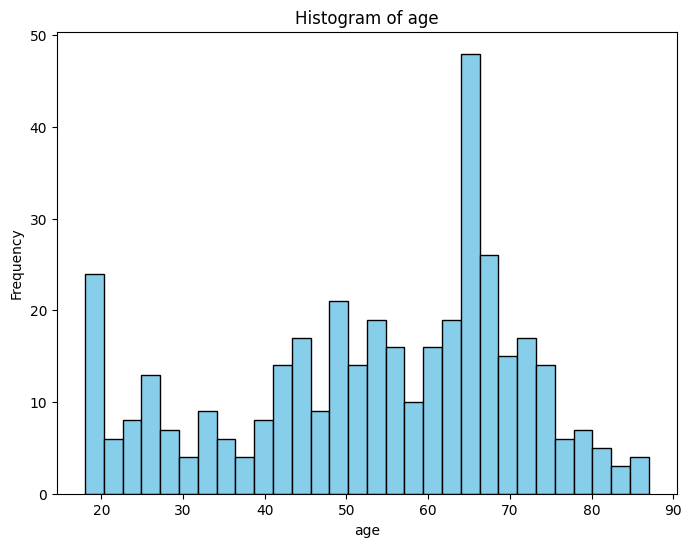

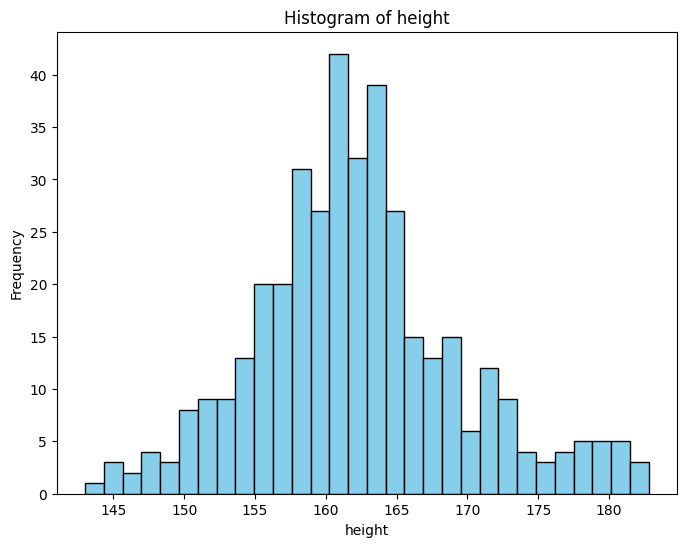

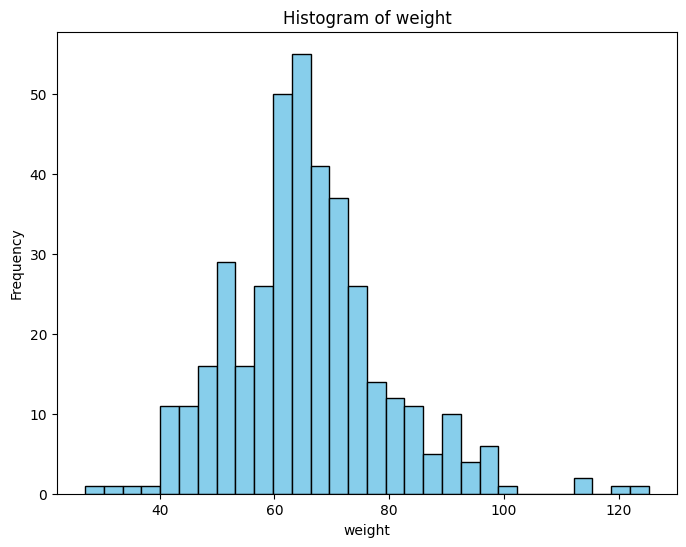

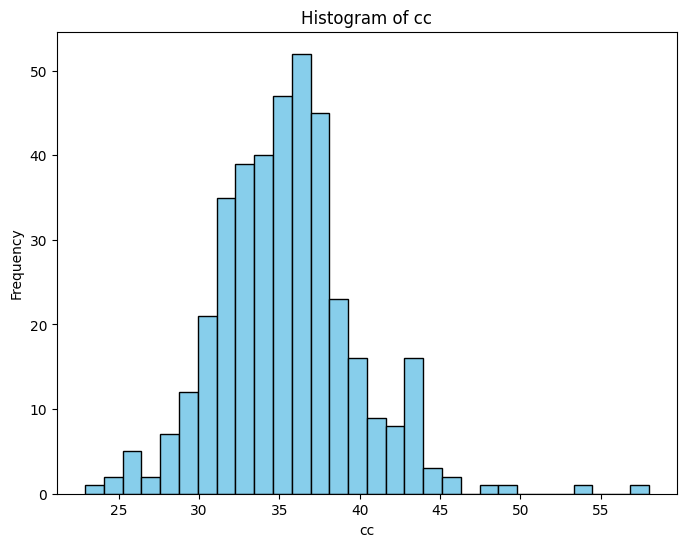

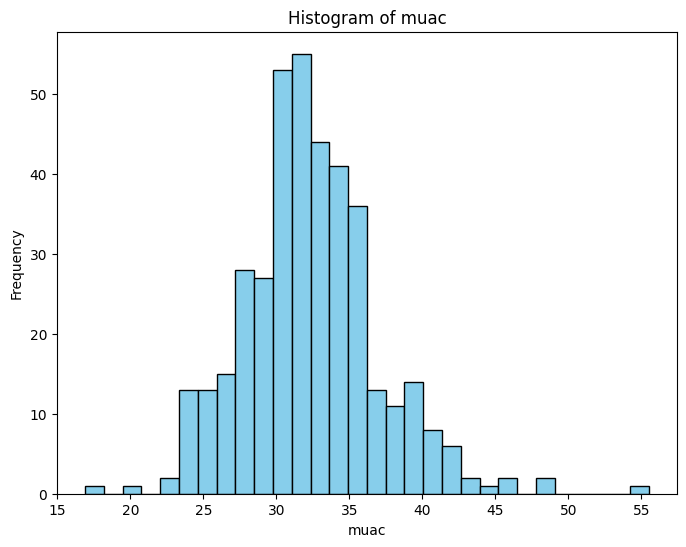

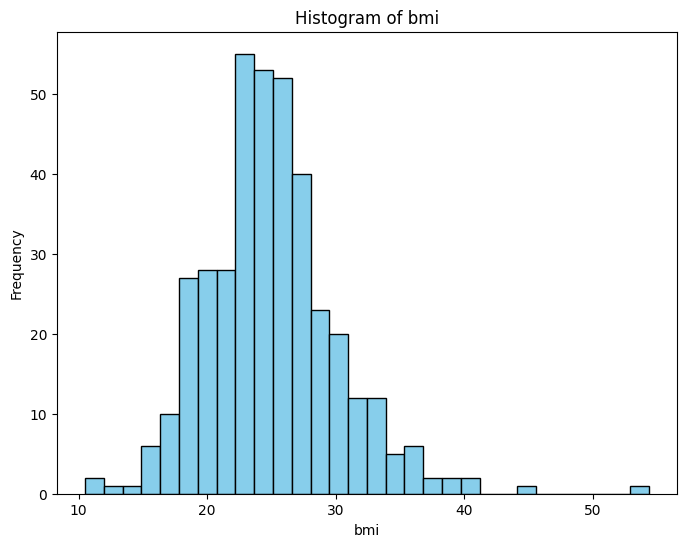

In [5]:
# Histogram of numeric variables
numeric_cols = df.select_dtypes(include=np.number).columns
for col in numeric_cols:
    plt.figure(figsize=(8, 6))
    plt.hist(df[col], bins=30, color='skyblue', edgecolor='black')
    plt.title(f'Histogram of {col}')
    plt.xlabel(f'{col}')
    plt.ylabel('Frequency')
    plt.show()

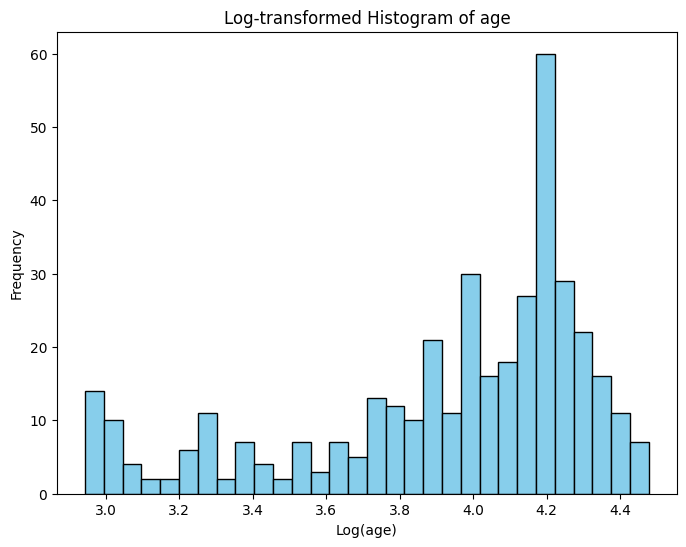

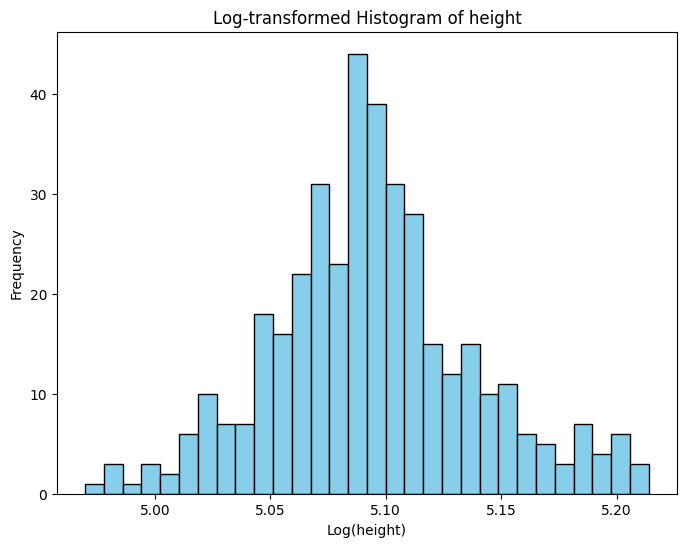

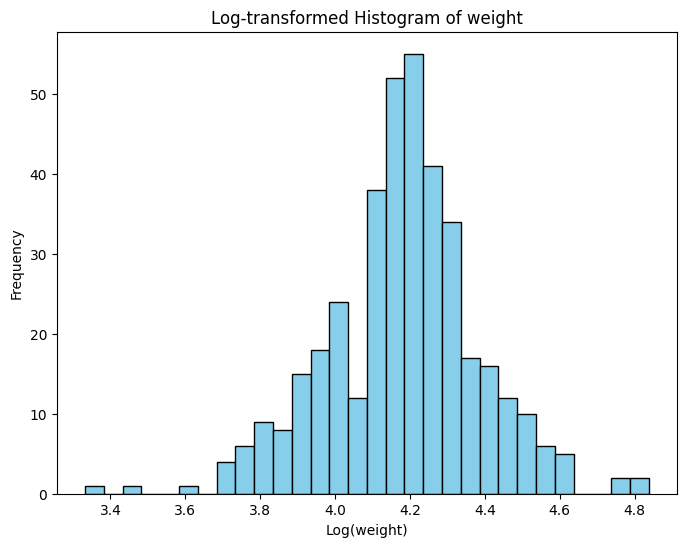

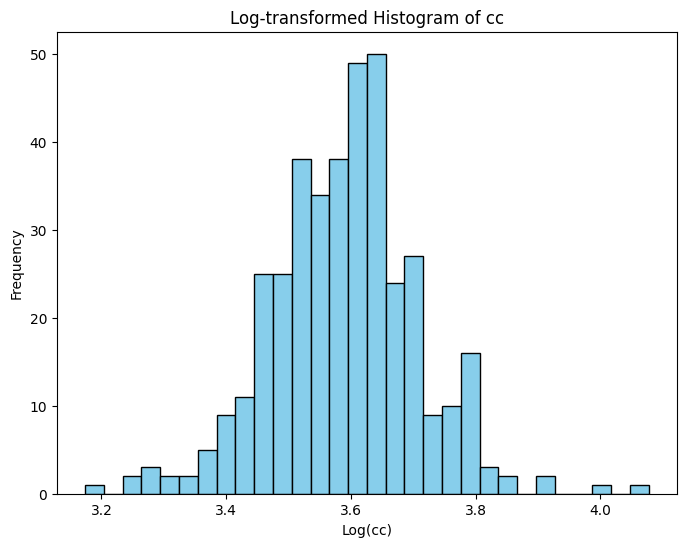

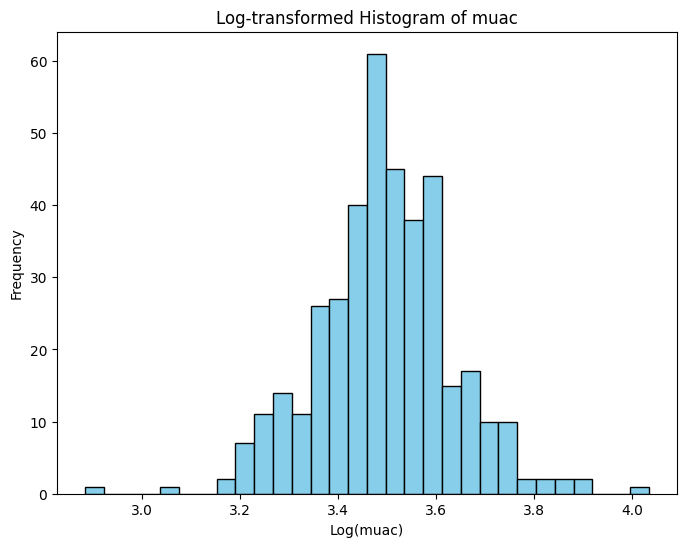

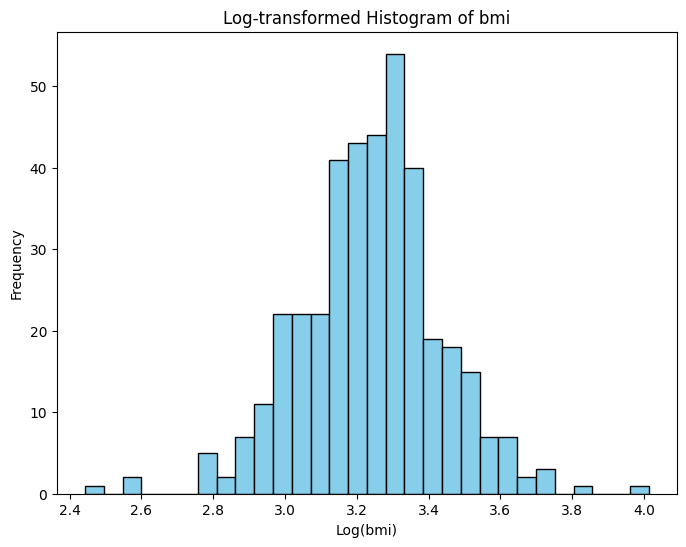

In [2]:
# Histogram of log transformed variables
numeric_cols = df.select_dtypes(include=np.number).columns
for col in numeric_cols:
    df[f'{col}_log'] = np.log1p(df[col])
    plt.figure(figsize=(8, 6))
    plt.hist(df[f'{col}_log'], bins=30, color='skyblue', edgecolor='black')
    plt.title(f'Log-transformed Histogram of {col}')
    plt.xlabel(f'Log({col})')
    plt.ylabel('Frequency')
    plt.show()

In [25]:
# Select features to retain
features = ["age", "sex", "height", "cc", "muac", "bmi_cat", "weight"]
muac_features = ["age", "sex", "muac", "weight"]
cc_features = ["age", "sex", "cc", "weight"]
cc_muac_features = ["age", "sex", "cc", "muac", "weight"]
cc_muac_bmi = ["age", "sex", "cc", "muac", "bmi_cat", "weight"]


# Training frames
df = df[features]
df_muac = df[muac_features]
df_cc = df[cc_features]
df_cc_muac = df[cc_muac_features]
df_cc_muac_bmi = df[cc_muac_bmi]


# Set y target
y = "weight"

In [ ]:
# Dimensions of the dataset


In [ ]:
# Dataset structure


In [ ]:
# View first five rows


In [ ]:
# Describe dataset


In [ ]:
# Distributions

# Automated Machine Learning

In [21]:
# Convert dataframe to H2O frame
df = h2o.H2OFrame(df)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [22]:
model_full = H2OAutoML(max_runtime_secs=600, seed=1, project_name="weight_prediction_full")
model_full.train(y=y, training_frame=df)

AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%


key,value
Stacking strategy,cross_validation
Number of base models (used / total),3/6
# GBM base models (used / total),1/1
# XGBoost base models (used / total),1/1
# DeepLearning base models (used / total),1/1
# GLM base models (used / total),0/1
# DRF base models (used / total),0/2
Metalearner algorithm,GLM
Metalearner fold assignment scheme,Random
Metalearner nfolds,5


In [23]:
model_full.leaderboard.head()

model_id,rmse,mse,mae,rmsle,mean_residual_deviance
StackedEnsemble_BestOfFamily_4_AutoML_1_20250310_151241,4.29705,18.4647,3.22946,0.0641981,18.4647
DeepLearning_grid_1_AutoML_1_20250310_151241_model_1,4.41609,19.5018,3.30919,0.0663527,19.5018
GBM_grid_1_AutoML_1_20250310_151241_model_58,4.53222,20.541,3.35702,0.0678286,20.541
StackedEnsemble_BestOfFamily_3_AutoML_1_20250310_151241,4.54007,20.6122,3.37844,0.0681753,20.6122
GBM_grid_1_AutoML_1_20250310_151241_model_2,4.54903,20.6937,3.35287,0.0679127,20.6937
GBM_grid_1_AutoML_1_20250310_151241_model_47,4.54913,20.6946,3.39004,0.0675566,20.6946
StackedEnsemble_AllModels_2_AutoML_1_20250310_151241,4.54935,20.6966,3.35357,0.0684329,20.6966
StackedEnsemble_AllModels_3_AutoML_1_20250310_151241,4.57768,20.9552,3.33737,0.0686942,20.9552
StackedEnsemble_AllModels_4_AutoML_1_20250310_151241,4.58982,21.0665,3.37286,0.0691435,21.0665
DeepLearning_grid_1_AutoML_1_20250310_151241_model_2,4.64553,21.5809,3.56856,0.0701301,21.5809


In [24]:
# Save full model
h2o.save_model(model_full.leader,  path="muac_model", force=True)

'/content/muac_model/StackedEnsemble_BestOfFamily_4_AutoML_1_20250310_151241'

## MUAC model

In [27]:
# Convert dataframe to H2O frame
df_muac = h2o.H2OFrame(df_muac)

model_muac = H2OAutoML(max_runtime_secs=600, seed=1, project_name="weight_prediction_muac")
model_muac.train(y=y, training_frame=df_muac)

AutoML progress: |
15:51:55.212: New models will be added to existing leaderboard weight_prediction_muac@@weight (leaderboard frame=null) with already 96 models.

 (failed)


OSError: Job with key $03017f00000132d4ffffffff$_8465c519d95d3593d7a9f490f1dd4624 failed with an exception: java.lang.StackOverflowError
stacktrace: 
java.lang.StackOverflowError
	at water.DKV.get(DKV.java:177)
	at water.Key.get(Key.java:86)
	at ai.h2o.automl.AutoML.leaderboard(AutoML.java:552)
	at ai.h2o.automl.ModelingStep.getTrainedModels(ModelingStep.java:317)
	at ai.h2o.automl.modeling.CompletionStepsProvider$CompletionSteps$ResumeBestNGridsStep.sortModelingStepByPerf(CompletionStepsProvider.java:72)
	at ai.h2o.automl.modeling.CompletionStepsProvider$CompletionSteps$ResumeBestNGridsStep.prepareModelingSteps(CompletionStepsProvider.java:97)
	at ai.h2o.automl.ModelingStep$DynamicStep.initSubSteps(ModelingStep.java:917)
	at ai.h2o.automl.ModelingStep$DynamicStep.getSubStep(ModelingStep.java:929)
	at ai.h2o.automl.ModelingSteps.lambda$getStep$0(ModelingSteps.java:28)
	at java.base/java.util.stream.ReferencePipeline$3$1.accept(ReferencePipeline.java:195)
	at java.base/java.util.Spliterators$ArraySpliterator.tryAdvance(Spliterators.java:958)
	at java.base/java.util.stream.ReferencePipeline.forEachWithCancel(ReferencePipeline.java:127)
	at java.base/java.util.stream.AbstractPipeline.copyIntoWithCancel(AbstractPipeline.java:502)
	at java.base/java.util.stream.AbstractPipeline.copyInto(AbstractPipeline.java:488)
	at java.base/java.util.stream.AbstractPipeline.wrapAndCopyInto(AbstractPipeline.java:474)
	at java.base/java.util.stream.FindOps$FindOp.evaluateSequential(FindOps.java:150)
	at java.base/java.util.stream.AbstractPipeline.evaluate(AbstractPipeline.java:234)
	at java.base/java.util.stream.ReferencePipeline.findFirst(ReferencePipeline.java:543)
	at ai.h2o.automl.ModelingSteps.getStep(ModelingSteps.java:31)
	at ai.h2o.automl.AutoMLSession.getModelingStep(AutoMLSession.java:67)
	at ai.h2o.automl.AutoMLSession.getModelingStep(AutoMLSession.java:62)
	at ai.h2o.automl.modeling.CompletionStepsProvider$CompletionSteps$ResumeBestNGridsStep.sortModelingStepByPerf(CompletionStepsProvider.java:76)
	at ai.h2o.automl.modeling.CompletionStepsProvider$CompletionSteps$ResumeBestNGridsStep.prepareModelingSteps(CompletionStepsProvider.java:97)
	at ai.h2o.automl.ModelingStep$DynamicStep.initSubSteps(ModelingStep.java:917)
	at ai.h2o.automl.ModelingStep$DynamicStep.getSubStep(ModelingStep.java:929)
	at ai.h2o.automl.ModelingSteps.lambda$getStep$0(ModelingSteps.java:28)
	at java.base/java.util.stream.ReferencePipeline$3$1.accept(ReferencePipeline.java:195)
	at java.base/java.util.Spliterators$ArraySpliterator.tryAdvance(Spliterators.java:958)
	at java.base/java.util.stream.ReferencePipeline.forEachWithCancel(ReferencePipeline.java:127)
	at java.base/java.util.stream.AbstractPipeline.copyIntoWithCancel(AbstractPipeline.java:502)
	at java.base/java.util.stream.AbstractPipeline.copyInto(AbstractPipeline.java:488)
	at java.base/java.util.stream.AbstractPipeline.wrapAndCopyInto(AbstractPipeline.java:474)
	at java.base/java.util.stream.FindOps$FindOp.evaluateSequential(FindOps.java:150)
	at java.base/java.util.stream.AbstractPipeline.evaluate(AbstractPipeline.java:234)
	at java.base/java.util.stream.ReferencePipeline.findFirst(ReferencePipeline.java:543)
	at ai.h2o.automl.ModelingSteps.getStep(ModelingSteps.java:31)
	at ai.h2o.automl.AutoMLSession.getModelingStep(AutoMLSession.java:67)
	at ai.h2o.automl.AutoMLSession.getModelingStep(AutoMLSession.java:62)
	at ai.h2o.automl.modeling.CompletionStepsProvider$CompletionSteps$ResumeBestNGridsStep.sortModelingStepByPerf(CompletionStepsProvider.java:76)
	at ai.h2o.automl.modeling.CompletionStepsProvider$CompletionSteps$ResumeBestNGridsStep.prepareModelingSteps(CompletionStepsProvider.java:97)
	at ai.h2o.automl.ModelingStep$DynamicStep.initSubSteps(ModelingStep.java:917)
	at ai.h2o.automl.ModelingStep$DynamicStep.getSubStep(ModelingStep.java:929)
	at ai.h2o.automl.ModelingSteps.lambda$getStep$0(ModelingSteps.java:28)
	at java.base/java.util.stream.ReferencePipeline$3$1.accept(ReferencePipeline.java:195)
	at java.base/java.util.Spliterators$ArraySpliterator.tryAdvance(Spliterators.java:958)
	at java.base/java.util.stream.ReferencePipeline.forEachWithCancel(ReferencePipeline.java:127)
	at java.base/java.util.stream.AbstractPipeline.copyIntoWithCancel(AbstractPipeline.java:502)
	at java.base/java.util.stream.AbstractPipeline.copyInto(AbstractPipeline.java:488)
	at java.base/java.util.stream.AbstractPipeline.wrapAndCopyInto(AbstractPipeline.java:474)
	at java.base/java.util.stream.FindOps$FindOp.evaluateSequential(FindOps.java:150)
	at java.base/java.util.stream.AbstractPipeline.evaluate(AbstractPipeline.java:234)
	at java.base/java.util.stream.ReferencePipeline.findFirst(ReferencePipeline.java:543)
	at ai.h2o.automl.ModelingSteps.getStep(ModelingSteps.java:31)
	at ai.h2o.automl.AutoMLSession.getModelingStep(AutoMLSession.java:67)
	at ai.h2o.automl.AutoMLSession.getModelingStep(AutoMLSession.java:62)
	at ai.h2o.automl.modeling.CompletionStepsProvider$CompletionSteps$ResumeBestNGridsStep.sortModelingStepByPerf(CompletionStepsProvider.java:76)
	at ai.h2o.automl.modeling.CompletionStepsProvider$CompletionSteps$ResumeBestNGridsStep.prepareModelingSteps(CompletionStepsProvider.java:97)
	at ai.h2o.automl.ModelingStep$DynamicStep.initSubSteps(ModelingStep.java:917)
	at ai.h2o.automl.ModelingStep$DynamicStep.getSubStep(ModelingStep.java:929)
	at ai.h2o.automl.ModelingSteps.lambda$getStep$0(ModelingSteps.java:28)
	at java.base/java.util.stream.ReferencePipeline$3$1.accept(ReferencePipeline.java:195)
	at java.base/java.util.Spliterators$ArraySpliterator.tryAdvance(Spliterators.java:958)
	at java.base/java.util.stream.ReferencePipeline.forEachWithCancel(ReferencePipeline.java:127)
	at java.base/java.util.stream.AbstractPipeline.copyIntoWithCancel(AbstractPipeline.java:502)
	at java.base/java.util.stream.AbstractPipeline.copyInto(AbstractPipeline.java:488)
	at java.base/java.util.stream.AbstractPipeline.wrapAndCopyInto(AbstractPipeline.java:474)
	at java.base/java.util.stream.FindOps$FindOp.evaluateSequential(FindOps.java:150)
	at java.base/java.util.stream.AbstractPipeline.evaluate(AbstractPipeline.java:234)
	at java.base/java.util.stream.ReferencePipeline.findFirst(ReferencePipeline.java:543)
	at ai.h2o.automl.ModelingSteps.getStep(ModelingSteps.java:31)
	at ai.h2o.automl.AutoMLSession.getModelingStep(AutoMLSession.java:67)
	at ai.h2o.automl.AutoMLSession.getModelingStep(AutoMLSession.java:62)
	at ai.h2o.automl.modeling.CompletionStepsProvider$CompletionSteps$ResumeBestNGridsStep.sortModelingStepByPerf(CompletionStepsProvider.java:76)
	at ai.h2o.automl.modeling.CompletionStepsProvider$CompletionSteps$ResumeBestNGridsStep.prepareModelingSteps(CompletionStepsProvider.java:97)
	at ai.h2o.automl.ModelingStep$DynamicStep.initSubSteps(ModelingStep.java:917)
	at ai.h2o.automl.ModelingStep$DynamicStep.getSubStep(ModelingStep.java:929)
	at ai.h2o.automl.ModelingSteps.lambda$getStep$0(ModelingSteps.java:28)
	at java.base/java.util.stream.ReferencePipeline$3$1.accept(ReferencePipeline.java:195)
	at java.base/java.util.Spliterators$ArraySpliterator.tryAdvance(Spliterators.java:958)
	at java.base/java.util.stream.ReferencePipeline.forEachWithCancel(ReferencePipeline.java:127)
	at java.base/java.util.stream.AbstractPipeline.copyIntoWithCancel(AbstractPipeline.java:502)
	at java.base/java.util.stream.AbstractPipeline.copyInto(AbstractPipeline.java:488)
	at java.base/java.util.stream.AbstractPipeline.wrapAndCopyInto(AbstractPipeline.java:474)
	at java.base/java.util.stream.FindOps$FindOp.evaluateSequential(FindOps.java:150)
	at java.base/java.util.stream.AbstractPipeline.evaluate(AbstractPipeline.java:234)
	at java.base/java.util.stream.ReferencePipeline.findFirst(ReferencePipeline.java:543)
	at ai.h2o.automl.ModelingSteps.getStep(ModelingSteps.java:31)
	at ai.h2o.automl.AutoMLSession.getModelingStep(AutoMLSession.java:67)
	at ai.h2o.automl.AutoMLSession.getModelingStep(AutoMLSession.java:62)
	at ai.h2o.automl.modeling.CompletionStepsProvider$CompletionSteps$ResumeBestNGridsStep.sortModelingStepByPerf(CompletionStepsProvider.java:76)
	at ai.h2o.automl.modeling.CompletionStepsProvider$CompletionSteps$ResumeBestNGridsStep.prepareModelingSteps(CompletionStepsProvider.java:97)
	at ai.h2o.automl.ModelingStep$DynamicStep.initSubSteps(ModelingStep.java:917)
	at ai.h2o.automl.ModelingStep$DynamicStep.getSubStep(ModelingStep.java:929)
	at ai.h2o.automl.ModelingSteps.lambda$getStep$0(ModelingSteps.java:28)
	at java.base/java.util.stream.ReferencePipeline$3$1.accept(ReferencePipeline.java:195)
	at java.base/java.util.Spliterators$ArraySpliterator.tryAdvance(Spliterators.java:958)
	at java.base/java.util.stream.ReferencePipeline.forEachWithCancel(ReferencePipeline.java:127)
	at java.base/java.util.stream.AbstractPipeline.copyIntoWithCancel(AbstractPipeline.java:502)
	at java.base/java.util.stream.AbstractPipeline.copyInto(AbstractPipeline.java:488)
	at java.base/java.util.stream.AbstractPipeline.wrapAndCopyInto(AbstractPipeline.java:474)
	at java.base/java.util.stream.FindOps$FindOp.evaluateSequential(FindOps.java:150)
	at java.base/java.util.stream.AbstractPipeline.evaluate(AbstractPipeline.java:234)
	at java.base/java.util.stream.ReferencePipeline.findFirst(ReferencePipeline.java:543)
	at ai.h2o.automl.ModelingSteps.getStep(ModelingSteps.java:31)
	at ai.h2o.automl.AutoMLSession.getModelingStep(AutoMLSession.java:67)
	at ai.h2o.automl.AutoMLSession.getModelingStep(AutoMLSession.java:62)
	at ai.h2o.automl.modeling.CompletionStepsProvider$CompletionSteps$ResumeBestNGridsStep.sortModelingStepByPerf(CompletionStepsProvider.java:76)
	at ai.h2o.automl.modeling.CompletionStepsProvider$CompletionSteps$ResumeBestNGridsStep.prepareModelingSteps(CompletionStepsProvider.java:97)
	at ai.h2o.automl.ModelingStep$DynamicStep.initSubSteps(ModelingStep.java:917)
	at ai.h2o.automl.ModelingStep$DynamicStep.getSubStep(ModelingStep.java:929)
	at ai.h2o.automl.ModelingSteps.lambda$getStep$0(ModelingSteps.java:28)
	at java.base/java.util.stream.ReferencePipeline$3$1.accept(ReferencePipeline.java:195)
	at java.base/java.util.Spliterators$ArraySpliterator.tryAdvance(Spliterators.java:958)
	at java.base/java.util.stream.ReferencePipeline.forEachWithCancel(ReferencePipeline.java:127)
	at java.base/java.util.stream.AbstractPipeline.copyIntoWithCancel(AbstractPipeline.java:502)
	at java.base/java.util.stream.AbstractPipeline.copyInto(AbstractPipeline.java:488)
	at java.base/java.util.stream.AbstractPipeline.wrapAndCopyInto(AbstractPipeline.java:474)
	at java.base/java.util.stream.FindOps$FindOp.evaluateSequential(FindOps.java:150)
	at java.base/java.util.stream.AbstractPipeline.evaluate(AbstractPipeline.java:234)
	at java.base/java.util.stream.ReferencePipeline.findFirst(ReferencePipeline.java:543)
	at ai.h2o.automl.ModelingSteps.getStep(ModelingSteps.java:31)
	at ai.h2o.automl.AutoMLSession.getModelingStep(AutoMLSession.java:67)
	at ai.h2o.automl.AutoMLSession.getModelingStep(AutoMLSession.java:62)
	at ai.h2o.automl.modeling.CompletionStepsProvider$CompletionSteps$ResumeBestNGridsStep.sortModelingStepByPerf(CompletionStepsProvider.java:76)
	at ai.h2o.automl.modeling.CompletionStepsProvider$CompletionSteps$ResumeBestNGridsStep.prepareModelingSteps(CompletionStepsProvider.java:97)
	at ai.h2o.automl.ModelingStep$DynamicStep.initSubSteps(ModelingStep.java:917)
	at ai.h2o.automl.ModelingStep$DynamicStep.getSubStep(ModelingStep.java:929)
	at ai.h2o.automl.ModelingSteps.lambda$getStep$0(ModelingSteps.java:28)
	at java.base/java.util.stream.ReferencePipeline$3$1.accept(ReferencePipeline.java:195)
	at java.base/java.util.Spliterators$ArraySpliterator.tryAdvance(Spliterators.java:958)
	at java.base/java.util.stream.ReferencePipeline.forEachWithCancel(ReferencePipeline.java:127)
	at java.base/java.util.stream.AbstractPipeline.copyIntoWithCancel(AbstractPipeline.java:502)
	at java.base/java.util.stream.AbstractPipeline.copyInto(AbstractPipeline.java:488)
	at java.base/java.util.stream.AbstractPipeline.wrapAndCopyInto(AbstractPipeline.java:474)
	at java.base/java.util.stream.FindOps$FindOp.evaluateSequential(FindOps.java:150)
	at java.base/java.util.stream.AbstractPipeline.evaluate(AbstractPipeline.java:234)
	at java.base/java.util.stream.ReferencePipeline.findFirst(ReferencePipeline.java:543)
	at ai.h2o.automl.ModelingSteps.getStep(ModelingSteps.java:31)
	at ai.h2o.automl.AutoMLSession.getModelingStep(AutoMLSession.java:67)
	at ai.h2o.automl.AutoMLSession.getModelingStep(AutoMLSession.java:62)
	at ai.h2o.automl.modeling.CompletionStepsProvider$CompletionSteps$ResumeBestNGridsStep.sortModelingStepByPerf(CompletionStepsProvider.java:76)
	at ai.h2o.automl.modeling.CompletionStepsProvider$CompletionSteps$ResumeBestNGridsStep.prepareModelingSteps(CompletionStepsProvider.java:97)
	at ai.h2o.automl.ModelingStep$DynamicStep.initSubSteps(ModelingStep.java:917)
	at ai.h2o.automl.ModelingStep$DynamicStep.getSubStep(ModelingStep.java:929)
	at ai.h2o.automl.ModelingSteps.lambda$getStep$0(ModelingSteps.java:28)
	at java.base/java.util.stream.ReferencePipeline$3$1.accept(ReferencePipeline.java:195)
	at java.base/java.util.Spliterators$ArraySpliterator.tryAdvance(Spliterators.java:958)
	at java.base/java.util.stream.ReferencePipeline.forEachWithCancel(ReferencePipeline.java:127)
	at java.base/java.util.stream.AbstractPipeline.copyIntoWithCancel(AbstractPipeline.java:502)
	at java.base/java.util.stream.AbstractPipeline.copyInto(AbstractPipeline.java:488)
	at java.base/java.util.stream.AbstractPipeline.wrapAndCopyInto(AbstractPipeline.java:474)
	at java.base/java.util.stream.FindOps$FindOp.evaluateSequential(FindOps.java:150)
	at java.base/java.util.stream.AbstractPipeline.evaluate(AbstractPipeline.java:234)
	at java.base/java.util.stream.ReferencePipeline.findFirst(ReferencePipeline.java:543)
	at ai.h2o.automl.ModelingSteps.getStep(ModelingSteps.java:31)
	at ai.h2o.automl.AutoMLSession.getModelingStep(AutoMLSession.java:67)
	at ai.h2o.automl.AutoMLSession.getModelingStep(AutoMLSession.java:62)
	at ai.h2o.automl.modeling.CompletionStepsProvider$CompletionSteps$ResumeBestNGridsStep.sortModelingStepByPerf(CompletionStepsProvider.java:76)
	at ai.h2o.automl.modeling.CompletionStepsProvider$CompletionSteps$ResumeBestNGridsStep.prepareModelingSteps(CompletionStepsProvider.java:97)
	at ai.h2o.automl.ModelingStep$DynamicStep.initSubSteps(ModelingStep.java:917)
	at ai.h2o.automl.ModelingStep$DynamicStep.getSubStep(ModelingStep.java:929)
	at ai.h2o.automl.ModelingSteps.lambda$getStep$0(ModelingSteps.java:28)
	at java.base/java.util.stream.ReferencePipeline$3$1.accept(ReferencePipeline.java:195)
	at java.base/java.util.Spliterators$ArraySpliterator.tryAdvance(Spliterators.java:958)
	at java.base/java.util.stream.ReferencePipeline.forEachWithCancel(ReferencePipeline.java:127)
	at java.base/java.util.stream.AbstractPipeline.copyIntoWithCancel(AbstractPipeline.java:502)
	at java.base/java.util.stream.AbstractPipeline.copyInto(AbstractPipeline.java:488)
	at java.base/java.util.stream.AbstractPipeline.wrapAndCopyInto(AbstractPipeline.java:474)
	at java.base/java.util.stream.FindOps$FindOp.evaluateSequential(FindOps.java:150)
	at java.base/java.util.stream.AbstractPipeline.evaluate(AbstractPipeline.java:234)
	at java.base/java.util.stream.ReferencePipeline.findFirst(ReferencePipeline.java:543)
	at ai.h2o.automl.ModelingSteps.getStep(ModelingSteps.java:31)
	at ai.h2o.automl.AutoMLSession.getModelingStep(AutoMLSession.java:67)
	at ai.h2o.automl.AutoMLSession.getModelingStep(AutoMLSession.java:62)
	at ai.h2o.automl.modeling.CompletionStepsProvider$CompletionSteps$ResumeBestNGridsStep.sortModelingStepByPerf(CompletionStepsProvider.java:76)
	at ai.h2o.automl.modeling.CompletionStepsProvider$CompletionSteps$ResumeBestNGridsStep.prepareModelingSteps(CompletionStepsProvider.java:97)
	at ai.h2o.automl.ModelingStep$DynamicStep.initSubSteps(ModelingStep.java:917)
	at ai.h2o.automl.ModelingStep$DynamicStep.getSubStep(ModelingStep.java:929)
	at ai.h2o.automl.ModelingSteps.lambda$getStep$0(ModelingSteps.java:28)
	at java.base/java.util.stream.ReferencePipeline$3$1.accept(ReferencePipeline.java:195)
	at java.base/java.util.Spliterators$ArraySpliterator.tryAdvance(Spliterators.java:958)
	at java.base/java.util.stream.ReferencePipeline.forEachWithCancel(ReferencePipeline.java:127)
	at java.base/java.util.stream.AbstractPipeline.copyIntoWithCancel(AbstractPipeline.java:502)
	at java.base/java.util.stream.AbstractPipeline.copyInto(AbstractPipeline.java:488)
	at java.base/java.util.stream.AbstractPipeline.wrapAndCopyInto(AbstractPipeline.java:474)
	at java.base/java.util.stream.FindOps$FindOp.evaluateSequential(FindOps.java:150)
	at java.base/java.util.stream.AbstractPipeline.evaluate(AbstractPipeline.java:234)
	at java.base/java.util.stream.ReferencePipeline.findFirst(ReferencePipeline.java:543)
	at ai.h2o.automl.ModelingSteps.getStep(ModelingSteps.java:31)
	at ai.h2o.automl.AutoMLSession.getModelingStep(AutoMLSession.java:67)
	at ai.h2o.automl.AutoMLSession.getModelingStep(AutoMLSession.java:62)
	at ai.h2o.automl.modeling.CompletionStepsProvider$CompletionSteps$ResumeBestNGridsStep.sortModelingStepByPerf(CompletionStepsProvider.java:76)
	at ai.h2o.automl.modeling.CompletionStepsProvider$CompletionSteps$ResumeBestNGridsStep.prepareModelingSteps(CompletionStepsProvider.java:97)
	at ai.h2o.automl.ModelingStep$DynamicStep.initSubSteps(ModelingStep.java:917)
	at ai.h2o.automl.ModelingStep$DynamicStep.getSubStep(ModelingStep.java:929)
	at ai.h2o.automl.ModelingSteps.lambda$getStep$0(ModelingSteps.java:28)
	at java.base/java.util.stream.ReferencePipeline$3$1.accept(ReferencePipeline.java:195)
	at java.base/java.util.Spliterators$ArraySpliterator.tryAdvance(Spliterators.java:958)
	at java.base/java.util.stream.ReferencePipeline.forEachWithCancel(ReferencePipeline.java:127)
	at java.base/java.util.stream.AbstractPipeline.copyIntoWithCancel(AbstractPipeline.java:502)
	at java.base/java.util.stream.AbstractPipeline.copyInto(AbstractPipeline.java:488)
	at java.base/java.util.stream.AbstractPipeline.wrapAndCopyInto(AbstractPipeline.java:474)
	at java.base/java.util.stream.FindOps$FindOp.evaluateSequential(FindOps.java:150)
	at java.base/java.util.stream.AbstractPipeline.evaluate(AbstractPipeline.java:234)
	at java.base/java.util.stream.ReferencePipeline.findFirst(ReferencePipeline.java:543)
	at ai.h2o.automl.ModelingSteps.getStep(ModelingSteps.java:31)
	at ai.h2o.automl.AutoMLSession.getModelingStep(AutoMLSession.java:67)
	at ai.h2o.automl.AutoMLSession.getModelingStep(AutoMLSession.java:62)
	at ai.h2o.automl.modeling.CompletionStepsProvider$CompletionSteps$ResumeBestNGridsStep.sortModelingStepByPerf(CompletionStepsProvider.java:76)
	at ai.h2o.automl.modeling.CompletionStepsProvider$CompletionSteps$ResumeBestNGridsStep.prepareModelingSteps(CompletionStepsProvider.java:97)
	at ai.h2o.automl.ModelingStep$DynamicStep.initSubSteps(ModelingStep.java:917)
	at ai.h2o.automl.ModelingStep$DynamicStep.getSubStep(ModelingStep.java:929)
	at ai.h2o.automl.ModelingSteps.lambda$getStep$0(ModelingSteps.java:28)
	at java.base/java.util.stream.ReferencePipeline$3$1.accept(ReferencePipeline.java:195)
	at java.base/java.util.Spliterators$ArraySpliterator.tryAdvance(Spliterators.java:958)
	at java.base/java.util.stream.ReferencePipeline.forEachWithCancel(ReferencePipeline.java:127)
	at java.base/java.util.stream.AbstractPipeline.copyIntoWithCancel(AbstractPipeline.java:502)
	at java.base/java.util.stream.AbstractPipeline.copyInto(AbstractPipeline.java:488)
	at java.base/java.util.stream.AbstractPipeline.wrapAndCopyInto(AbstractPipeline.java:474)
	at java.base/java.util.stream.FindOps$FindOp.evaluateSequential(FindOps.java:150)
	at java.base/java.util.stream.AbstractPipeline.evaluate(AbstractPipeline.java:234)
	at java.base/java.util.stream.ReferencePipeline.findFirst(ReferencePipeline.java:543)
	at ai.h2o.automl.ModelingSteps.getStep(ModelingSteps.java:31)
	at ai.h2o.automl.AutoMLSession.getModelingStep(AutoMLSession.java:67)
	at ai.h2o.automl.AutoMLSession.getModelingStep(AutoMLSession.java:62)
	at ai.h2o.automl.modeling.CompletionStepsProvider$CompletionSteps$ResumeBestNGridsStep.sortModelingStepByPerf(CompletionStepsProvider.java:76)
	at ai.h2o.automl.modeling.CompletionStepsProvider$CompletionSteps$ResumeBestNGridsStep.prepareModelingSteps(CompletionStepsProvider.java:97)
	at ai.h2o.automl.ModelingStep$DynamicStep.initSubSteps(ModelingStep.java:917)
	at ai.h2o.automl.ModelingStep$DynamicStep.getSubStep(ModelingStep.java:929)
	at ai.h2o.automl.ModelingSteps.lambda$getStep$0(ModelingSteps.java:28)
	at java.base/java.util.stream.ReferencePipeline$3$1.accept(ReferencePipeline.java:195)
	at java.base/java.util.Spliterators$ArraySpliterator.tryAdvance(Spliterators.java:958)
	at java.base/java.util.stream.ReferencePipeline.forEachWithCancel(ReferencePipeline.java:127)
	at java.base/java.util.stream.AbstractPipeline.copyIntoWithCancel(AbstractPipeline.java:502)
	at java.base/java.util.stream.AbstractPipeline.copyInto(AbstractPipeline.java:488)
	at java.base/java.util.stream.AbstractPipeline.wrapAndCopyInto(AbstractPipeline.java:474)
	at java.base/java.util.stream.FindOps$FindOp.evaluateSequential(FindOps.java:150)
	at java.base/java.util.stream.AbstractPipeline.evaluate(AbstractPipeline.java:234)
	at java.base/java.util.stream.ReferencePipeline.findFirst(ReferencePipeline.java:543)
	at ai.h2o.automl.ModelingSteps.getStep(ModelingSteps.java:31)
	at ai.h2o.automl.AutoMLSession.getModelingStep(AutoMLSession.java:67)
	at ai.h2o.automl.AutoMLSession.getModelingStep(AutoMLSession.java:62)
	at ai.h2o.automl.modeling.CompletionStepsProvider$CompletionSteps$ResumeBestNGridsStep.sortModelingStepByPerf(CompletionStepsProvider.java:76)
	at ai.h2o.automl.modeling.CompletionStepsProvider$CompletionSteps$ResumeBestNGridsStep.prepareModelingSteps(CompletionStepsProvider.java:97)
	at ai.h2o.automl.ModelingStep$DynamicStep.initSubSteps(ModelingStep.java:917)
	at ai.h2o.automl.ModelingStep$DynamicStep.getSubStep(ModelingStep.java:929)
	at ai.h2o.automl.ModelingSteps.lambda$getStep$0(ModelingSteps.java:28)
	at java.base/java.util.stream.ReferencePipeline$3$1.accept(ReferencePipeline.java:195)
	at java.base/java.util.Spliterators$ArraySpliterator.tryAdvance(Spliterators.java:958)
	at java.base/java.util.stream.ReferencePipeline.forEachWithCancel(ReferencePipeline.java:127)
	at java.base/java.util.stream.AbstractPipeline.copyIntoWithCancel(AbstractPipeline.java:502)
	at java.base/java.util.stream.AbstractPipeline.copyInto(AbstractPipeline.java:488)
	at java.base/java.util.stream.AbstractPipeline.wrapAndCopyInto(AbstractPipeline.java:474)
	at java.base/java.util.stream.FindOps$FindOp.evaluateSequential(FindOps.java:150)
	at java.base/java.util.stream.AbstractPipeline.evaluate(AbstractPipeline.java:234)
	at java.base/java.util.stream.ReferencePipeline.findFirst(ReferencePipeline.java:543)
	at ai.h2o.automl.ModelingSteps.getStep(ModelingSteps.java:31)
	at ai.h2o.automl.AutoMLSession.getModelingStep(AutoMLSession.java:67)
	at ai.h2o.automl.AutoMLSession.getModelingStep(AutoMLSession.java:62)
	at ai.h2o.automl.modeling.CompletionStepsProvider$CompletionSteps$ResumeBestNGridsStep.sortModelingStepByPerf(CompletionStepsProvider.java:76)
	at ai.h2o.automl.modeling.CompletionStepsProvider$CompletionSteps$ResumeBestNGridsStep.prepareModelingSteps(CompletionStepsProvider.java:97)
	at ai.h2o.automl.ModelingStep$DynamicStep.initSubSteps(ModelingStep.java:917)
	at ai.h2o.automl.ModelingStep$DynamicStep.getSubStep(ModelingStep.java:929)
	at ai.h2o.automl.ModelingSteps.lambda$getStep$0(ModelingSteps.java:28)
	at java.base/java.util.stream.ReferencePipeline$3$1.accept(ReferencePipeline.java:195)
	at java.base/java.util.Spliterators$ArraySpliterator.tryAdvance(Spliterators.java:958)
	at java.base/java.util.stream.ReferencePipeline.forEachWithCancel(ReferencePipeline.java:127)
	at java.base/java.util.stream.AbstractPipeline.copyIntoWithCancel(AbstractPipeline.java:502)
	at java.base/java.util.stream.AbstractPipeline.copyInto(AbstractPipeline.java:488)
	at java.base/java.util.stream.AbstractPipeline.wrapAndCopyInto(AbstractPipeline.java:474)
	at java.base/java.util.stream.FindOps$FindOp.evaluateSequential(FindOps.java:150)
	at java.base/java.util.stream.AbstractPipeline.evaluate(AbstractPipeline.java:234)
	at java.base/java.util.stream.ReferencePipeline.findFirst(ReferencePipeline.java:543)
	at ai.h2o.automl.ModelingSteps.getStep(ModelingSteps.java:31)
	at ai.h2o.automl.AutoMLSession.getModelingStep(AutoMLSession.java:67)
	at ai.h2o.automl.AutoMLSession.getModelingStep(AutoMLSession.java:62)
	at ai.h2o.automl.modeling.CompletionStepsProvider$CompletionSteps$ResumeBestNGridsStep.sortModelingStepByPerf(CompletionStepsProvider.java:76)
	at ai.h2o.automl.modeling.CompletionStepsProvider$CompletionSteps$ResumeBestNGridsStep.prepareModelingSteps(CompletionStepsProvider.java:97)
	at ai.h2o.automl.ModelingStep$DynamicStep.initSubSteps(ModelingStep.java:917)
	at ai.h2o.automl.ModelingStep$DynamicStep.getSubStep(ModelingStep.java:929)
	at ai.h2o.automl.ModelingSteps.lambda$getStep$0(ModelingSteps.java:28)
	at java.base/java.util.stream.ReferencePipeline$3$1.accept(ReferencePipeline.java:195)
	at java.base/java.util.Spliterators$ArraySpliterator.tryAdvance(Spliterators.java:958)
	at java.base/java.util.stream.ReferencePipeline.forEachWithCancel(ReferencePipeline.java:127)
	at java.base/java.util.stream.AbstractPipeline.copyIntoWithCancel(AbstractPipeline.java:502)
	at java.base/java.util.stream.AbstractPipeline.copyInto(AbstractPipeline.java:488)
	at java.base/java.util.stream.AbstractPipeline.wrapAndCopyInto(AbstractPipeline.java:474)
	at java.base/java.util.stream.FindOps$FindOp.evaluateSequential(FindOps.java:150)
	at java.base/java.util.stream.AbstractPipeline.evaluate(AbstractPipeline.java:234)
	at java.base/java.util.stream.ReferencePipeline.findFirst(ReferencePipeline.java:543)
	at ai.h2o.automl.ModelingSteps.getStep(ModelingSteps.java:31)
	at ai.h2o.automl.AutoMLSession.getModelingStep(AutoMLSession.java:67)
	at ai.h2o.automl.AutoMLSession.getModelingStep(AutoMLSession.java:62)
	at ai.h2o.automl.modeling.CompletionStepsProvider$CompletionSteps$ResumeBestNGridsStep.sortModelingStepByPerf(CompletionStepsProvider.java:76)
	at ai.h2o.automl.modeling.CompletionStepsProvider$CompletionSteps$ResumeBestNGridsStep.prepareModelingSteps(CompletionStepsProvider.java:97)
	at ai.h2o.automl.ModelingStep$DynamicStep.initSubSteps(ModelingStep.java:917)
	at ai.h2o.automl.ModelingStep$DynamicStep.getSubStep(ModelingStep.java:929)
	at ai.h2o.automl.ModelingSteps.lambda$getStep$0(ModelingSteps.java:28)
	at java.base/java.util.stream.ReferencePipeline$3$1.accept(ReferencePipeline.java:195)
	at java.base/java.util.Spliterators$ArraySpliterator.tryAdvance(Spliterators.java:958)
	at java.base/java.util.stream.ReferencePipeline.forEachWithCancel(ReferencePipeline.java:127)
	at java.base/java.util.stream.AbstractPipeline.copyIntoWithCancel(AbstractPipeline.java:502)
	at java.base/java.util.stream.AbstractPipeline.copyInto(AbstractPipeline.java:488)
	at java.base/java.util.stream.AbstractPipeline.wrapAndCopyInto(AbstractPipeline.java:474)
	at java.base/java.util.stream.FindOps$FindOp.evaluateSequential(FindOps.java:150)
	at java.base/java.util.stream.AbstractPipeline.evaluate(AbstractPipeline.java:234)
	at java.base/java.util.stream.ReferencePipeline.findFirst(ReferencePipeline.java:543)
	at ai.h2o.automl.ModelingSteps.getStep(ModelingSteps.java:31)
	at ai.h2o.automl.AutoMLSession.getModelingStep(AutoMLSession.java:67)
	at ai.h2o.automl.AutoMLSession.getModelingStep(AutoMLSession.java:62)
	at ai.h2o.automl.modeling.CompletionStepsProvider$CompletionSteps$ResumeBestNGridsStep.sortModelingStepByPerf(CompletionStepsProvider.java:76)
	at ai.h2o.automl.modeling.CompletionStepsProvider$CompletionSteps$ResumeBestNGridsStep.prepareModelingSteps(CompletionStepsProvider.java:97)
	at ai.h2o.automl.ModelingStep$DynamicStep.initSubSteps(ModelingStep.java:917)
	at ai.h2o.automl.ModelingStep$DynamicStep.getSubStep(ModelingStep.java:929)
	at ai.h2o.automl.ModelingSteps.lambda$getStep$0(ModelingSteps.java:28)
	at java.base/java.util.stream.ReferencePipeline$3$1.accept(ReferencePipeline.java:195)
	at java.base/java.util.Spliterators$ArraySpliterator.tryAdvance(Spliterators.java:958)
	at java.base/java.util.stream.ReferencePipeline.forEachWithCancel(ReferencePipeline.java:127)
	at java.base/java.util.stream.AbstractPipeline.copyIntoWithCancel(AbstractPipeline.java:502)
	at java.base/java.util.stream.AbstractPipeline.copyInto(AbstractPipeline.java:488)
	at java.base/java.util.stream.AbstractPipeline.wrapAndCopyInto(AbstractPipeline.java:474)
	at java.base/java.util.stream.FindOps$FindOp.evaluateSequential(FindOps.java:150)
	at java.base/java.util.stream.AbstractPipeline.evaluate(AbstractPipeline.java:234)
	at java.base/java.util.stream.ReferencePipeline.findFirst(ReferencePipeline.java:543)
	at ai.h2o.automl.ModelingSteps.getStep(ModelingSteps.java:31)
	at ai.h2o.automl.AutoMLSession.getModelingStep(AutoMLSession.java:67)
	at ai.h2o.automl.AutoMLSession.getModelingStep(AutoMLSession.java:62)
	at ai.h2o.automl.modeling.CompletionStepsProvider$CompletionSteps$ResumeBestNGridsStep.sortModelingStepByPerf(CompletionStepsProvider.java:76)
	at ai.h2o.automl.modeling.CompletionStepsProvider$CompletionSteps$ResumeBestNGridsStep.prepareModelingSteps(CompletionStepsProvider.java:97)
	at ai.h2o.automl.ModelingStep$DynamicStep.initSubSteps(ModelingStep.java:917)
	at ai.h2o.automl.ModelingStep$DynamicStep.getSubStep(ModelingStep.java:929)
	at ai.h2o.automl.ModelingSteps.lambda$getStep$0(ModelingSteps.java:28)
	at java.base/java.util.stream.ReferencePipeline$3$1.accept(ReferencePipeline.java:195)
	at java.base/java.util.Spliterators$ArraySpliterator.tryAdvance(Spliterators.java:958)
	at java.base/java.util.stream.ReferencePipeline.forEachWithCancel(ReferencePipeline.java:127)
	at java.base/java.util.stream.AbstractPipeline.copyIntoWithCancel(AbstractPipeline.java:502)
	at java.base/java.util.stream.AbstractPipeline.copyInto(AbstractPipeline.java:488)
	at java.base/java.util.stream.AbstractPipeline.wrapAndCopyInto(AbstractPipeline.java:474)
	at java.base/java.util.stream.FindOps$FindOp.evaluateSequential(FindOps.java:150)
	at java.base/java.util.stream.AbstractPipeline.evaluate(AbstractPipeline.java:234)
	at java.base/java.util.stream.ReferencePipeline.findFirst(ReferencePipeline.java:543)
	at ai.h2o.automl.ModelingSteps.getStep(ModelingSteps.java:31)
	at ai.h2o.automl.AutoMLSession.getModelingStep(AutoMLSession.java:67)
	at ai.h2o.automl.AutoMLSession.getModelingStep(AutoMLSession.java:62)
	at ai.h2o.automl.modeling.CompletionStepsProvider$CompletionSteps$ResumeBestNGridsStep.sortModelingStepByPerf(CompletionStepsProvider.java:76)
	at ai.h2o.automl.modeling.CompletionStepsProvider$CompletionSteps$ResumeBestNGridsStep.prepareModelingSteps(CompletionStepsProvider.java:97)
	at ai.h2o.automl.ModelingStep$DynamicStep.initSubSteps(ModelingStep.java:917)
	at ai.h2o.automl.ModelingStep$DynamicStep.getSubStep(ModelingStep.java:929)
	at ai.h2o.automl.ModelingSteps.lambda$getStep$0(ModelingSteps.java:28)
	at java.base/java.util.stream.ReferencePipeline$3$1.accept(ReferencePipeline.java:195)
	at java.base/java.util.Spliterators$ArraySpliterator.tryAdvance(Spliterators.java:958)
	at java.base/java.util.stream.ReferencePipeline.forEachWithCancel(ReferencePipeline.java:127)
	at java.base/java.util.stream.AbstractPipeline.copyIntoWithCancel(AbstractPipeline.java:502)
	at java.base/java.util.stream.AbstractPipeline.copyInto(AbstractPipeline.java:488)
	at java.base/java.util.stream.AbstractPipeline.wrapAndCopyInto(AbstractPipeline.java:474)
	at java.base/java.util.stream.FindOps$FindOp.evaluateSequential(FindOps.java:150)
	at java.base/java.util.stream.AbstractPipeline.evaluate(AbstractPipeline.java:234)
	at java.base/java.util.stream.ReferencePipeline.findFirst(ReferencePipeline.java:543)
	at ai.h2o.automl.ModelingSteps.getStep(ModelingSteps.java:31)
	at ai.h2o.automl.AutoMLSession.getModelingStep(AutoMLSession.java:67)
	at ai.h2o.automl.AutoMLSession.getModelingStep(AutoMLSession.java:62)
	at ai.h2o.automl.modeling.CompletionStepsProvider$CompletionSteps$ResumeBestNGridsStep.sortModelingStepByPerf(CompletionStepsProvider.java:76)
	at ai.h2o.automl.modeling.CompletionStepsProvider$CompletionSteps$ResumeBestNGridsStep.prepareModelingSteps(CompletionStepsProvider.java:97)
	at ai.h2o.automl.ModelingStep$DynamicStep.initSubSteps(ModelingStep.java:917)
	at ai.h2o.automl.ModelingStep$DynamicStep.getSubStep(ModelingStep.java:929)
	at ai.h2o.automl.ModelingSteps.lambda$getStep$0(ModelingSteps.java:28)
	at java.base/java.util.stream.ReferencePipeline$3$1.accept(ReferencePipeline.java:195)
	at java.base/java.util.Spliterators$ArraySpliterator.tryAdvance(Spliterators.java:958)
	at java.base/java.util.stream.ReferencePipeline.forEachWithCancel(ReferencePipeline.java:127)
	at java.base/java.util.stream.AbstractPipeline.copyIntoWithCancel(AbstractPipeline.java:502)
	at java.base/java.util.stream.AbstractPipeline.copyInto(AbstractPipeline.java:488)
	at java.base/java.util.stream.AbstractPipeline.wrapAndCopyInto(AbstractPipeline.java:474)
	at java.base/java.util.stream.FindOps$FindOp.evaluateSequential(FindOps.java:150)
	at java.base/java.util.stream.AbstractPipeline.evaluate(AbstractPipeline.java:234)
	at java.base/java.util.stream.ReferencePipeline.findFirst(ReferencePipeline.java:543)
	at ai.h2o.automl.ModelingSteps.getStep(ModelingSteps.java:31)
	at ai.h2o.automl.AutoMLSession.getModelingStep(AutoMLSession.java:67)
	at ai.h2o.automl.AutoMLSession.getModelingStep(AutoMLSession.java:62)
	at ai.h2o.automl.modeling.CompletionStepsProvider$CompletionSteps$ResumeBestNGridsStep.sortModelingStepByPerf(CompletionStepsProvider.java:76)
	at ai.h2o.automl.modeling.CompletionStepsProvider$CompletionSteps$ResumeBestNGridsStep.prepareModelingSteps(CompletionStepsProvider.java:97)
	at ai.h2o.automl.ModelingStep$DynamicStep.initSubSteps(ModelingStep.java:917)
	at ai.h2o.automl.ModelingStep$DynamicStep.getSubStep(ModelingStep.java:929)
	at ai.h2o.automl.ModelingSteps.lambda$getStep$0(ModelingSteps.java:28)
	at java.base/java.util.stream.ReferencePipeline$3$1.accept(ReferencePipeline.java:195)
	at java.base/java.util.Spliterators$ArraySpliterator.tryAdvance(Spliterators.java:958)
	at java.base/java.util.stream.ReferencePipeline.forEachWithCancel(ReferencePipeline.java:127)
	at java.base/java.util.stream.AbstractPipeline.copyIntoWithCancel(AbstractPipeline.java:502)
	at java.base/java.util.stream.AbstractPipeline.copyInto(AbstractPipeline.java:488)
	at java.base/java.util.stream.AbstractPipeline.wrapAndCopyInto(AbstractPipeline.java:474)
	at java.base/java.util.stream.FindOps$FindOp.evaluateSequential(FindOps.java:150)
	at java.base/java.util.stream.AbstractPipeline.evaluate(AbstractPipeline.java:234)
	at java.base/java.util.stream.ReferencePipeline.findFirst(ReferencePipeline.java:543)
	at ai.h2o.automl.ModelingSteps.getStep(ModelingSteps.java:31)
	at ai.h2o.automl.AutoMLSession.getModelingStep(AutoMLSession.java:67)
	at ai.h2o.automl.AutoMLSession.getModelingStep(AutoMLSession.java:62)
	at ai.h2o.automl.modeling.CompletionStepsProvider$CompletionSteps$ResumeBestNGridsStep.sortModelingStepByPerf(CompletionStepsProvider.java:76)
	at ai.h2o.automl.modeling.CompletionStepsProvider$CompletionSteps$ResumeBestNGridsStep.prepareModelingSteps(CompletionStepsProvider.java:97)
	at ai.h2o.automl.ModelingStep$DynamicStep.initSubSteps(ModelingStep.java:917)
	at ai.h2o.automl.ModelingStep$DynamicStep.getSubStep(ModelingStep.java:929)
	at ai.h2o.automl.ModelingSteps.lambda$getStep$0(ModelingSteps.java:28)
	at java.base/java.util.stream.ReferencePipeline$3$1.accept(ReferencePipeline.java:195)
	at java.base/java.util.Spliterators$ArraySpliterator.tryAdvance(Spliterators.java:958)
	at java.base/java.util.stream.ReferencePipeline.forEachWithCancel(ReferencePipeline.java:127)
	at java.base/java.util.stream.AbstractPipeline.copyIntoWithCancel(AbstractPipeline.java:502)
	at java.base/java.util.stream.AbstractPipeline.copyInto(AbstractPipeline.java:488)
	at java.base/java.util.stream.AbstractPipeline.wrapAndCopyInto(AbstractPipeline.java:474)
	at java.base/java.util.stream.FindOps$FindOp.evaluateSequential(FindOps.java:150)
	at java.base/java.util.stream.AbstractPipeline.evaluate(AbstractPipeline.java:234)
	at java.base/java.util.stream.ReferencePipeline.findFirst(ReferencePipeline.java:543)
	at ai.h2o.automl.ModelingSteps.getStep(ModelingSteps.java:31)
	at ai.h2o.automl.AutoMLSession.getModelingStep(AutoMLSession.java:67)
	at ai.h2o.automl.AutoMLSession.getModelingStep(AutoMLSession.java:62)
	at ai.h2o.automl.modeling.CompletionStepsProvider$CompletionSteps$ResumeBestNGridsStep.sortModelingStepByPerf(CompletionStepsProvider.java:76)
	at ai.h2o.automl.modeling.CompletionStepsProvider$CompletionSteps$ResumeBestNGridsStep.prepareModelingSteps(CompletionStepsProvider.java:97)
	at ai.h2o.automl.ModelingStep$DynamicStep.initSubSteps(ModelingStep.java:917)
	at ai.h2o.automl.ModelingStep$DynamicStep.getSubStep(ModelingStep.java:929)
	at ai.h2o.automl.ModelingSteps.lambda$getStep$0(ModelingSteps.java:28)
	at java.base/java.util.stream.ReferencePipeline$3$1.accept(ReferencePipeline.java:195)
	at java.base/java.util.Spliterators$ArraySpliterator.tryAdvance(Spliterators.java:958)
	at java.base/java.util.stream.ReferencePipeline.forEachWithCancel(ReferencePipeline.java:127)
	at java.base/java.util.stream.AbstractPipeline.copyIntoWithCancel(AbstractPipeline.java:502)
	at java.base/java.util.stream.AbstractPipeline.copyInto(AbstractPipeline.java:488)
	at java.base/java.util.stream.AbstractPipeline.wrapAndCopyInto(AbstractPipeline.java:474)
	at java.base/java.util.stream.FindOps$FindOp.evaluateSequential(FindOps.java:150)
	at java.base/java.util.stream.AbstractPipeline.evaluate(AbstractPipeline.java:234)
	at java.base/java.util.stream.ReferencePipeline.findFirst(ReferencePipeline.java:543)
	at ai.h2o.automl.ModelingSteps.getStep(ModelingSteps.java:31)
	at ai.h2o.automl.AutoMLSession.getModelingStep(AutoMLSession.java:67)
	at ai.h2o.automl.AutoMLSession.getModelingStep(AutoMLSession.java:62)
	at ai.h2o.automl.modeling.CompletionStepsProvider$CompletionSteps$ResumeBestNGridsStep.sortModelingStepByPerf(CompletionStepsProvider.java:76)
	at ai.h2o.automl.modeling.CompletionStepsProvider$CompletionSteps$ResumeBestNGridsStep.prepareModelingSteps(CompletionStepsProvider.java:97)
	at ai.h2o.automl.ModelingStep$DynamicStep.initSubSteps(ModelingStep.java:917)
	at ai.h2o.automl.ModelingStep$DynamicStep.getSubStep(ModelingStep.java:929)
	at ai.h2o.automl.ModelingSteps.lambda$getStep$0(ModelingSteps.java:28)
	at java.base/java.util.stream.ReferencePipeline$3$1.accept(ReferencePipeline.java:195)
	at java.base/java.util.Spliterators$ArraySpliterator.tryAdvance(Spliterators.java:958)
	at java.base/java.util.stream.ReferencePipeline.forEachWithCancel(ReferencePipeline.java:127)
	at java.base/java.util.stream.AbstractPipeline.copyIntoWithCancel(AbstractPipeline.java:502)
	at java.base/java.util.stream.AbstractPipeline.copyInto(AbstractPipeline.java:488)
	at java.base/java.util.stream.AbstractPipeline.wrapAndCopyInto(AbstractPipeline.java:474)
	at java.base/java.util.stream.FindOps$FindOp.evaluateSequential(FindOps.java:150)
	at java.base/java.util.stream.AbstractPipeline.evaluate(AbstractPipeline.java:234)
	at java.base/java.util.stream.ReferencePipeline.findFirst(ReferencePipeline.java:543)
	at ai.h2o.automl.ModelingSteps.getStep(ModelingSteps.java:31)
	at ai.h2o.automl.AutoMLSession.getModelingStep(AutoMLSession.java:67)
	at ai.h2o.automl.AutoMLSession.getModelingStep(AutoMLSession.java:62)
	at ai.h2o.automl.modeling.CompletionStepsProvider$CompletionSteps$ResumeBestNGridsStep.sortModelingStepByPerf(CompletionStepsProvider.java:76)
	at ai.h2o.automl.modeling.CompletionStepsProvider$CompletionSteps$ResumeBestNGridsStep.prepareModelingSteps(CompletionStepsProvider.java:97)
	at ai.h2o.automl.ModelingStep$DynamicStep.initSubSteps(ModelingStep.java:917)
	at ai.h2o.automl.ModelingStep$DynamicStep.getSubStep(ModelingStep.java:929)
	at ai.h2o.automl.ModelingSteps.lambda$getStep$0(ModelingSteps.java:28)
	at java.base/java.util.stream.ReferencePipeline$3$1.accept(ReferencePipeline.java:195)
	at java.base/java.util.Spliterators$ArraySpliterator.tryAdvance(Spliterators.java:958)
	at java.base/java.util.stream.ReferencePipeline.forEachWithCancel(ReferencePipeline.java:127)
	at java.base/java.util.stream.AbstractPipeline.copyIntoWithCancel(AbstractPipeline.java:502)
	at java.base/java.util.stream.AbstractPipeline.copyInto(AbstractPipeline.java:488)
	at java.base/java.util.stream.AbstractPipeline.wrapAndCopyInto(AbstractPipeline.java:474)
	at java.base/java.util.stream.FindOps$FindOp.evaluateSequential(FindOps.java:150)
	at java.base/java.util.stream.AbstractPipeline.evaluate(AbstractPipeline.java:234)
	at java.base/java.util.stream.ReferencePipeline.findFirst(ReferencePipeline.java:543)
	at ai.h2o.automl.ModelingSteps.getStep(ModelingSteps.java:31)
	at ai.h2o.automl.AutoMLSession.getModelingStep(AutoMLSession.java:67)
	at ai.h2o.automl.AutoMLSession.getModelingStep(AutoMLSession.java:62)
	at ai.h2o.automl.modeling.CompletionStepsProvider$CompletionSteps$ResumeBestNGridsStep.sortModelingStepByPerf(CompletionStepsProvider.java:76)
	at ai.h2o.automl.modeling.CompletionStepsProvider$CompletionSteps$ResumeBestNGridsStep.prepareModelingSteps(CompletionStepsProvider.java:97)
	at ai.h2o.automl.ModelingStep$DynamicStep.initSubSteps(ModelingStep.java:917)
	at ai.h2o.automl.ModelingStep$DynamicStep.getSubStep(ModelingStep.java:929)
	at ai.h2o.automl.ModelingSteps.lambda$getStep$0(ModelingSteps.java:28)
	at java.base/java.util.stream.ReferencePipeline$3$1.accept(ReferencePipeline.java:195)
	at java.base/java.util.Spliterators$ArraySpliterator.tryAdvance(Spliterators.java:958)
	at java.base/java.util.stream.ReferencePipeline.forEachWithCancel(ReferencePipeline.java:127)
	at java.base/java.util.stream.AbstractPipeline.copyIntoWithCancel(AbstractPipeline.java:502)
	at java.base/java.util.stream.AbstractPipeline.copyInto(AbstractPipeline.java:488)
	at java.base/java.util.stream.AbstractPipeline.wrapAndCopyInto(AbstractPipeline.java:474)
	at java.base/java.util.stream.FindOps$FindOp.evaluateSequential(FindOps.java:150)
	at java.base/java.util.stream.AbstractPipeline.evaluate(AbstractPipeline.java:234)
	at java.base/java.util.stream.ReferencePipeline.findFirst(ReferencePipeline.java:543)
	at ai.h2o.automl.ModelingSteps.getStep(ModelingSteps.java:31)
	at ai.h2o.automl.AutoMLSession.getModelingStep(AutoMLSession.java:67)
	at ai.h2o.automl.AutoMLSession.getModelingStep(AutoMLSession.java:62)
	at ai.h2o.automl.modeling.CompletionStepsProvider$CompletionSteps$ResumeBestNGridsStep.sortModelingStepByPerf(CompletionStepsProvider.java:76)
	at ai.h2o.automl.modeling.CompletionStepsProvider$CompletionSteps$ResumeBestNGridsStep.prepareModelingSteps(CompletionStepsProvider.java:97)
	at ai.h2o.automl.ModelingStep$DynamicStep.initSubSteps(ModelingStep.java:917)
	at ai.h2o.automl.ModelingStep$DynamicStep.getSubStep(ModelingStep.java:929)
	at ai.h2o.automl.ModelingSteps.lambda$getStep$0(ModelingSteps.java:28)
	at java.base/java.util.stream.ReferencePipeline$3$1.accept(ReferencePipeline.java:195)
	at java.base/java.util.Spliterators$ArraySpliterator.tryAdvance(Spliterators.java:958)
	at java.base/java.util.stream.ReferencePipeline.forEachWithCancel(ReferencePipeline.java:127)
	at java.base/java.util.stream.AbstractPipeline.copyIntoWithCancel(AbstractPipeline.java:502)
	at java.base/java.util.stream.AbstractPipeline.copyInto(AbstractPipeline.java:488)
	at java.base/java.util.stream.AbstractPipeline.wrapAndCopyInto(AbstractPipeline.java:474)
	at java.base/java.util.stream.FindOps$FindOp.evaluateSequential(FindOps.java:150)
	at java.base/java.util.stream.AbstractPipeline.evaluate(AbstractPipeline.java:234)
	at java.base/java.util.stream.ReferencePipeline.findFirst(ReferencePipeline.java:543)
	at ai.h2o.automl.ModelingSteps.getStep(ModelingSteps.java:31)
	at ai.h2o.automl.AutoMLSession.getModelingStep(AutoMLSession.java:67)
	at ai.h2o.automl.AutoMLSession.getModelingStep(AutoMLSession.java:62)
	at ai.h2o.automl.modeling.CompletionStepsProvider$CompletionSteps$ResumeBestNGridsStep.sortModelingStepByPerf(CompletionStepsProvider.java:76)
	at ai.h2o.automl.modeling.CompletionStepsProvider$CompletionSteps$ResumeBestNGridsStep.prepareModelingSteps(CompletionStepsProvider.java:97)
	at ai.h2o.automl.ModelingStep$DynamicStep.initSubSteps(ModelingStep.java:917)
	at ai.h2o.automl.ModelingStep$DynamicStep.getSubStep(ModelingStep.java:929)
	at ai.h2o.automl.ModelingSteps.lambda$getStep$0(ModelingSteps.java:28)
	at java.base/java.util.stream.ReferencePipeline$3$1.accept(ReferencePipeline.java:195)
	at java.base/java.util.Spliterators$ArraySpliterator.tryAdvance(Spliterators.java:958)
	at java.base/java.util.stream.ReferencePipeline.forEachWithCancel(ReferencePipeline.java:127)
	at java.base/java.util.stream.AbstractPipeline.copyIntoWithCancel(AbstractPipeline.java:502)
	at java.base/java.util.stream.AbstractPipeline.copyInto(AbstractPipeline.java:488)
	at java.base/java.util.stream.AbstractPipeline.wrapAndCopyInto(AbstractPipeline.java:474)
	at java.base/java.util.stream.FindOps$FindOp.evaluateSequential(FindOps.java:150)
	at java.base/java.util.stream.AbstractPipeline.evaluate(AbstractPipeline.java:234)
	at java.base/java.util.stream.ReferencePipeline.findFirst(ReferencePipeline.java:543)
	at ai.h2o.automl.ModelingSteps.getStep(ModelingSteps.java:31)
	at ai.h2o.automl.AutoMLSession.getModelingStep(AutoMLSession.java:67)
	at ai.h2o.automl.AutoMLSession.getModelingStep(AutoMLSession.java:62)
	at ai.h2o.automl.modeling.CompletionStepsProvider$CompletionSteps$ResumeBestNGridsStep.sortModelingStepByPerf(CompletionStepsProvider.java:76)
	at ai.h2o.automl.modeling.CompletionStepsProvider$CompletionSteps$ResumeBestNGridsStep.prepareModelingSteps(CompletionStepsProvider.java:97)
	at ai.h2o.automl.ModelingStep$DynamicStep.initSubSteps(ModelingStep.java:917)
	at ai.h2o.automl.ModelingStep$DynamicStep.getSubStep(ModelingStep.java:929)
	at ai.h2o.automl.ModelingSteps.lambda$getStep$0(ModelingSteps.java:28)
	at java.base/java.util.stream.ReferencePipeline$3$1.accept(ReferencePipeline.java:195)
	at java.base/java.util.Spliterators$ArraySpliterator.tryAdvance(Spliterators.java:958)
	at java.base/java.util.stream.ReferencePipeline.forEachWithCancel(ReferencePipeline.java:127)
	at java.base/java.util.stream.AbstractPipeline.copyIntoWithCancel(AbstractPipeline.java:502)
	at java.base/java.util.stream.AbstractPipeline.copyInto(AbstractPipeline.java:488)
	at java.base/java.util.stream.AbstractPipeline.wrapAndCopyInto(AbstractPipeline.java:474)
	at java.base/java.util.stream.FindOps$FindOp.evaluateSequential(FindOps.java:150)
	at java.base/java.util.stream.AbstractPipeline.evaluate(AbstractPipeline.java:234)
	at java.base/java.util.stream.ReferencePipeline.findFirst(ReferencePipeline.java:543)
	at ai.h2o.automl.ModelingSteps.getStep(ModelingSteps.java:31)
	at ai.h2o.automl.AutoMLSession.getModelingStep(AutoMLSession.java:67)
	at ai.h2o.automl.AutoMLSession.getModelingStep(AutoMLSession.java:62)
	at ai.h2o.automl.modeling.CompletionStepsProvider$CompletionSteps$ResumeBestNGridsStep.sortModelingStepByPerf(CompletionStepsProvider.java:76)
	at ai.h2o.automl.modeling.CompletionStepsProvider$CompletionSteps$ResumeBestNGridsStep.prepareModelingSteps(CompletionStepsProvider.java:97)
	at ai.h2o.automl.ModelingStep$DynamicStep.initSubSteps(ModelingStep.java:917)
	at ai.h2o.automl.ModelingStep$DynamicStep.getSubStep(ModelingStep.java:929)
	at ai.h2o.automl.ModelingSteps.lambda$getStep$0(ModelingSteps.java:28)
	at java.base/java.util.stream.ReferencePipeline$3$1.accept(ReferencePipeline.java:195)
	at java.base/java.util.Spliterators$ArraySpliterator.tryAdvance(Spliterators.java:958)
	at java.base/java.util.stream.ReferencePipeline.forEachWithCancel(ReferencePipeline.java:127)
	at java.base/java.util.stream.AbstractPipeline.copyIntoWithCancel(AbstractPipeline.java:502)
	at java.base/java.util.stream.AbstractPipeline.copyInto(AbstractPipeline.java:488)
	at java.base/java.util.stream.AbstractPipeline.wrapAndCopyInto(AbstractPipeline.java:474)
	at java.base/java.util.stream.FindOps$FindOp.evaluateSequential(FindOps.java:150)
	at java.base/java.util.stream.AbstractPipeline.evaluate(AbstractPipeline.java:234)
	at java.base/java.util.stream.ReferencePipeline.findFirst(ReferencePipeline.java:543)
	at ai.h2o.automl.ModelingSteps.getStep(ModelingSteps.java:31)
	at ai.h2o.automl.AutoMLSession.getModelingStep(AutoMLSession.java:67)
	at ai.h2o.automl.AutoMLSession.getModelingStep(AutoMLSession.java:62)
	at ai.h2o.automl.modeling.CompletionStepsProvider$CompletionSteps$ResumeBestNGridsStep.sortModelingStepByPerf(CompletionStepsProvider.java:76)
	at ai.h2o.automl.modeling.CompletionStepsProvider$CompletionSteps$ResumeBestNGridsStep.prepareModelingSteps(CompletionStepsProvider.java:97)
	at ai.h2o.automl.ModelingStep$DynamicStep.initSubSteps(ModelingStep.java:917)
	at ai.h2o.automl.ModelingStep$DynamicStep.getSubStep(ModelingStep.java:929)
	at ai.h2o.automl.ModelingSteps.lambda$getStep$0(ModelingSteps.java:28)
	at java.base/java.util.stream.ReferencePipeline$3$1.accept(ReferencePipeline.java:195)
	at java.base/java.util.Spliterators$ArraySpliterator.tryAdvance(Spliterators.java:958)
	at java.base/java.util.stream.ReferencePipeline.forEachWithCancel(ReferencePipeline.java:127)
	at java.base/java.util.stream.AbstractPipeline.copyIntoWithCancel(AbstractPipeline.java:502)
	at java.base/java.util.stream.AbstractPipeline.copyInto(AbstractPipeline.java:488)
	at java.base/java.util.stream.AbstractPipeline.wrapAndCopyInto(AbstractPipeline.java:474)
	at java.base/java.util.stream.FindOps$FindOp.evaluateSequential(FindOps.java:150)
	at java.base/java.util.stream.AbstractPipeline.evaluate(AbstractPipeline.java:234)
	at java.base/java.util.stream.ReferencePipeline.findFirst(ReferencePipeline.java:543)
	at ai.h2o.automl.ModelingSteps.getStep(ModelingSteps.java:31)
	at ai.h2o.automl.AutoMLSession.getModelingStep(AutoMLSession.java:67)
	at ai.h2o.automl.AutoMLSession.getModelingStep(AutoMLSession.java:62)
	at ai.h2o.automl.modeling.CompletionStepsProvider$CompletionSteps$ResumeBestNGridsStep.sortModelingStepByPerf(CompletionStepsProvider.java:76)
	at ai.h2o.automl.modeling.CompletionStepsProvider$CompletionSteps$ResumeBestNGridsStep.prepareModelingSteps(CompletionStepsProvider.java:97)
	at ai.h2o.automl.ModelingStep$DynamicStep.initSubSteps(ModelingStep.java:917)
	at ai.h2o.automl.ModelingStep$DynamicStep.getSubStep(ModelingStep.java:929)
	at ai.h2o.automl.ModelingSteps.lambda$getStep$0(ModelingSteps.java:28)
	at java.base/java.util.stream.ReferencePipeline$3$1.accept(ReferencePipeline.java:195)
	at java.base/java.util.Spliterators$ArraySpliterator.tryAdvance(Spliterators.java:958)
	at java.base/java.util.stream.ReferencePipeline.forEachWithCancel(ReferencePipeline.java:127)
	at java.base/java.util.stream.AbstractPipeline.copyIntoWithCancel(AbstractPipeline.java:502)
	at java.base/java.util.stream.AbstractPipeline.copyInto(AbstractPipeline.java:488)
	at java.base/java.util.stream.AbstractPipeline.wrapAndCopyInto(AbstractPipeline.java:474)
	at java.base/java.util.stream.FindOps$FindOp.evaluateSequential(FindOps.java:150)
	at java.base/java.util.stream.AbstractPipeline.evaluate(AbstractPipeline.java:234)
	at java.base/java.util.stream.ReferencePipeline.findFirst(ReferencePipeline.java:543)
	at ai.h2o.automl.ModelingSteps.getStep(ModelingSteps.java:31)
	at ai.h2o.automl.AutoMLSession.getModelingStep(AutoMLSession.java:67)
	at ai.h2o.automl.AutoMLSession.getModelingStep(AutoMLSession.java:62)
	at ai.h2o.automl.modeling.CompletionStepsProvider$CompletionSteps$ResumeBestNGridsStep.sortModelingStepByPerf(CompletionStepsProvider.java:76)
	at ai.h2o.automl.modeling.CompletionStepsProvider$CompletionSteps$ResumeBestNGridsStep.prepareModelingSteps(CompletionStepsProvider.java:97)
	at ai.h2o.automl.ModelingStep$DynamicStep.initSubSteps(ModelingStep.java:917)
	at ai.h2o.automl.ModelingStep$DynamicStep.getSubStep(ModelingStep.java:929)
	at ai.h2o.automl.ModelingSteps.lambda$getStep$0(ModelingSteps.java:28)
	at java.base/java.util.stream.ReferencePipeline$3$1.accept(ReferencePipeline.java:195)
	at java.base/java.util.Spliterators$ArraySpliterator.tryAdvance(Spliterators.java:958)
	at java.base/java.util.stream.ReferencePipeline.forEachWithCancel(ReferencePipeline.java:127)
	at java.base/java.util.stream.AbstractPipeline.copyIntoWithCancel(AbstractPipeline.java:502)
	at java.base/java.util.stream.AbstractPipeline.copyInto(AbstractPipeline.java:488)
	at java.base/java.util.stream.AbstractPipeline.wrapAndCopyInto(AbstractPipeline.java:474)
	at java.base/java.util.stream.FindOps$FindOp.evaluateSequential(FindOps.java:150)
	at java.base/java.util.stream.AbstractPipeline.evaluate(AbstractPipeline.java:234)
	at java.base/java.util.stream.ReferencePipeline.findFirst(ReferencePipeline.java:543)
	at ai.h2o.automl.ModelingSteps.getStep(ModelingSteps.java:31)
	at ai.h2o.automl.AutoMLSession.getModelingStep(AutoMLSession.java:67)
	at ai.h2o.automl.AutoMLSession.getModelingStep(AutoMLSession.java:62)
	at ai.h2o.automl.modeling.CompletionStepsProvider$CompletionSteps$ResumeBestNGridsStep.sortModelingStepByPerf(CompletionStepsProvider.java:76)
	at ai.h2o.automl.modeling.CompletionStepsProvider$CompletionSteps$ResumeBestNGridsStep.prepareModelingSteps(CompletionStepsProvider.java:97)
	at ai.h2o.automl.ModelingStep$DynamicStep.initSubSteps(ModelingStep.java:917)
	at ai.h2o.automl.ModelingStep$DynamicStep.getSubStep(ModelingStep.java:929)
	at ai.h2o.automl.ModelingSteps.lambda$getStep$0(ModelingSteps.java:28)
	at java.base/java.util.stream.ReferencePipeline$3$1.accept(ReferencePipeline.java:195)
	at java.base/java.util.Spliterators$ArraySpliterator.tryAdvance(Spliterators.java:958)
	at java.base/java.util.stream.ReferencePipeline.forEachWithCancel(ReferencePipeline.java:127)
	at java.base/java.util.stream.AbstractPipeline.copyIntoWithCancel(AbstractPipeline.java:502)
	at java.base/java.util.stream.AbstractPipeline.copyInto(AbstractPipeline.java:488)
	at java.base/java.util.stream.AbstractPipeline.wrapAndCopyInto(AbstractPipeline.java:474)
	at java.base/java.util.stream.FindOps$FindOp.evaluateSequential(FindOps.java:150)
	at java.base/java.util.stream.AbstractPipeline.evaluate(AbstractPipeline.java:234)
	at java.base/java.util.stream.ReferencePipeline.findFirst(ReferencePipeline.java:543)
	at ai.h2o.automl.ModelingSteps.getStep(ModelingSteps.java:31)
	at ai.h2o.automl.AutoMLSession.getModelingStep(AutoMLSession.java:67)
	at ai.h2o.automl.AutoMLSession.getModelingStep(AutoMLSession.java:62)
	at ai.h2o.automl.modeling.CompletionStepsProvider$CompletionSteps$ResumeBestNGridsStep.sortModelingStepByPerf(CompletionStepsProvider.java:76)
	at ai.h2o.automl.modeling.CompletionStepsProvider$CompletionSteps$ResumeBestNGridsStep.prepareModelingSteps(CompletionStepsProvider.java:97)
	at ai.h2o.automl.ModelingStep$DynamicStep.initSubSteps(ModelingStep.java:917)
	at ai.h2o.automl.ModelingStep$DynamicStep.getSubStep(ModelingStep.java:929)
	at ai.h2o.automl.ModelingSteps.lambda$getStep$0(ModelingSteps.java:28)
	at java.base/java.util.stream.ReferencePipeline$3$1.accept(ReferencePipeline.java:195)
	at java.base/java.util.Spliterators$ArraySpliterator.tryAdvance(Spliterators.java:958)
	at java.base/java.util.stream.ReferencePipeline.forEachWithCancel(ReferencePipeline.java:127)
	at java.base/java.util.stream.AbstractPipeline.copyIntoWithCancel(AbstractPipeline.java:502)
	at java.base/java.util.stream.AbstractPipeline.copyInto(AbstractPipeline.java:488)
	at java.base/java.util.stream.AbstractPipeline.wrapAndCopyInto(AbstractPipeline.java:474)
	at java.base/java.util.stream.FindOps$FindOp.evaluateSequential(FindOps.java:150)
	at java.base/java.util.stream.AbstractPipeline.evaluate(AbstractPipeline.java:234)
	at java.base/java.util.stream.ReferencePipeline.findFirst(ReferencePipeline.java:543)
	at ai.h2o.automl.ModelingSteps.getStep(ModelingSteps.java:31)
	at ai.h2o.automl.AutoMLSession.getModelingStep(AutoMLSession.java:67)
	at ai.h2o.automl.AutoMLSession.getModelingStep(AutoMLSession.java:62)
	at ai.h2o.automl.modeling.CompletionStepsProvider$CompletionSteps$ResumeBestNGridsStep.sortModelingStepByPerf(CompletionStepsProvider.java:76)
	at ai.h2o.automl.modeling.CompletionStepsProvider$CompletionSteps$ResumeBestNGridsStep.prepareModelingSteps(CompletionStepsProvider.java:97)
	at ai.h2o.automl.ModelingStep$DynamicStep.initSubSteps(ModelingStep.java:917)
	at ai.h2o.automl.ModelingStep$DynamicStep.getSubStep(ModelingStep.java:929)
	at ai.h2o.automl.ModelingSteps.lambda$getStep$0(ModelingSteps.java:28)
	at java.base/java.util.stream.ReferencePipeline$3$1.accept(ReferencePipeline.java:195)
	at java.base/java.util.Spliterators$ArraySpliterator.tryAdvance(Spliterators.java:958)
	at java.base/java.util.stream.ReferencePipeline.forEachWithCancel(ReferencePipeline.java:127)
	at java.base/java.util.stream.AbstractPipeline.copyIntoWithCancel(AbstractPipeline.java:502)
	at java.base/java.util.stream.AbstractPipeline.copyInto(AbstractPipeline.java:488)
	at java.base/java.util.stream.AbstractPipeline.wrapAndCopyInto(AbstractPipeline.java:474)
	at java.base/java.util.stream.FindOps$FindOp.evaluateSequential(FindOps.java:150)
	at java.base/java.util.stream.AbstractPipeline.evaluate(AbstractPipeline.java:234)
	at java.base/java.util.stream.ReferencePipeline.findFirst(ReferencePipeline.java:543)
	at ai.h2o.automl.ModelingSteps.getStep(ModelingSteps.java:31)
	at ai.h2o.automl.AutoMLSession.getModelingStep(AutoMLSession.java:67)
	at ai.h2o.automl.AutoMLSession.getModelingStep(AutoMLSession.java:62)
	at ai.h2o.automl.modeling.CompletionStepsProvider$CompletionSteps$ResumeBestNGridsStep.sortModelingStepByPerf(CompletionStepsProvider.java:76)
	at ai.h2o.automl.modeling.CompletionStepsProvider$CompletionSteps$ResumeBestNGridsStep.prepareModelingSteps(CompletionStepsProvider.java:97)
	at ai.h2o.automl.ModelingStep$DynamicStep.initSubSteps(ModelingStep.java:917)
	at ai.h2o.automl.ModelingStep$DynamicStep.getSubStep(ModelingStep.java:929)
	at ai.h2o.automl.ModelingSteps.lambda$getStep$0(ModelingSteps.java:28)
	at java.base/java.util.stream.ReferencePipeline$3$1.accept(ReferencePipeline.java:195)
	at java.base/java.util.Spliterators$ArraySpliterator.tryAdvance(Spliterators.java:958)
	at java.base/java.util.stream.ReferencePipeline.forEachWithCancel(ReferencePipeline.java:127)
	at java.base/java.util.stream.AbstractPipeline.copyIntoWithCancel(AbstractPipeline.java:502)
	at java.base/java.util.stream.AbstractPipeline.copyInto(AbstractPipeline.java:488)
	at java.base/java.util.stream.AbstractPipeline.wrapAndCopyInto(AbstractPipeline.java:474)
	at java.base/java.util.stream.FindOps$FindOp.evaluateSequential(FindOps.java:150)
	at java.base/java.util.stream.AbstractPipeline.evaluate(AbstractPipeline.java:234)
	at java.base/java.util.stream.ReferencePipeline.findFirst(ReferencePipeline.java:543)
	at ai.h2o.automl.ModelingSteps.getStep(ModelingSteps.java:31)
	at ai.h2o.automl.AutoMLSession.getModelingStep(AutoMLSession.java:67)
	at ai.h2o.automl.AutoMLSession.getModelingStep(AutoMLSession.java:62)
	at ai.h2o.automl.modeling.CompletionStepsProvider$CompletionSteps$ResumeBestNGridsStep.sortModelingStepByPerf(CompletionStepsProvider.java:76)
	at ai.h2o.automl.modeling.CompletionStepsProvider$CompletionSteps$ResumeBestNGridsStep.prepareModelingSteps(CompletionStepsProvider.java:97)
	at ai.h2o.automl.ModelingStep$DynamicStep.initSubSteps(ModelingStep.java:917)
	at ai.h2o.automl.ModelingStep$DynamicStep.getSubStep(ModelingStep.java:929)
	at ai.h2o.automl.ModelingSteps.lambda$getStep$0(ModelingSteps.java:28)
	at java.base/java.util.stream.ReferencePipeline$3$1.accept(ReferencePipeline.java:195)
	at java.base/java.util.Spliterators$ArraySpliterator.tryAdvance(Spliterators.java:958)
	at java.base/java.util.stream.ReferencePipeline.forEachWithCancel(ReferencePipeline.java:127)
	at java.base/java.util.stream.AbstractPipeline.copyIntoWithCancel(AbstractPipeline.java:502)
	at java.base/java.util.stream.AbstractPipeline.copyInto(AbstractPipeline.java:488)
	at java.base/java.util.stream.AbstractPipeline.wrapAndCopyInto(AbstractPipeline.java:474)
	at java.base/java.util.stream.FindOps$FindOp.evaluateSequential(FindOps.java:150)
	at java.base/java.util.stream.AbstractPipeline.evaluate(AbstractPipeline.java:234)
	at java.base/java.util.stream.ReferencePipeline.findFirst(ReferencePipeline.java:543)
	at ai.h2o.automl.ModelingSteps.getStep(ModelingSteps.java:31)
	at ai.h2o.automl.AutoMLSession.getModelingStep(AutoMLSession.java:67)
	at ai.h2o.automl.AutoMLSession.getModelingStep(AutoMLSession.java:62)
	at ai.h2o.automl.modeling.CompletionStepsProvider$CompletionSteps$ResumeBestNGridsStep.sortModelingStepByPerf(CompletionStepsProvider.java:76)
	at ai.h2o.automl.modeling.CompletionStepsProvider$CompletionSteps$ResumeBestNGridsStep.prepareModelingSteps(CompletionStepsProvider.java:97)
	at ai.h2o.automl.ModelingStep$DynamicStep.initSubSteps(ModelingStep.java:917)
	at ai.h2o.automl.ModelingStep$DynamicStep.getSubStep(ModelingStep.java:929)
	at ai.h2o.automl.ModelingSteps.lambda$getStep$0(ModelingSteps.java:28)
	at java.base/java.util.stream.ReferencePipeline$3$1.accept(ReferencePipeline.java:195)
	at java.base/java.util.Spliterators$ArraySpliterator.tryAdvance(Spliterators.java:958)
	at java.base/java.util.stream.ReferencePipeline.forEachWithCancel(ReferencePipeline.java:127)
	at java.base/java.util.stream.AbstractPipeline.copyIntoWithCancel(AbstractPipeline.java:502)
	at java.base/java.util.stream.AbstractPipeline.copyInto(AbstractPipeline.java:488)
	at java.base/java.util.stream.AbstractPipeline.wrapAndCopyInto(AbstractPipeline.java:474)
	at java.base/java.util.stream.FindOps$FindOp.evaluateSequential(FindOps.java:150)
	at java.base/java.util.stream.AbstractPipeline.evaluate(AbstractPipeline.java:234)
	at java.base/java.util.stream.ReferencePipeline.findFirst(ReferencePipeline.java:543)
	at ai.h2o.automl.ModelingSteps.getStep(ModelingSteps.java:31)
	at ai.h2o.automl.AutoMLSession.getModelingStep(AutoMLSession.java:67)
	at ai.h2o.automl.AutoMLSession.getModelingStep(AutoMLSession.java:62)
	at ai.h2o.automl.modeling.CompletionStepsProvider$CompletionSteps$ResumeBestNGridsStep.sortModelingStepByPerf(CompletionStepsProvider.java:76)
	at ai.h2o.automl.modeling.CompletionStepsProvider$CompletionSteps$ResumeBestNGridsStep.prepareModelingSteps(CompletionStepsProvider.java:97)
	at ai.h2o.automl.ModelingStep$DynamicStep.initSubSteps(ModelingStep.java:917)
	at ai.h2o.automl.ModelingStep$DynamicStep.getSubStep(ModelingStep.java:929)
	at ai.h2o.automl.ModelingSteps.lambda$getStep$0(ModelingSteps.java:28)
	at java.base/java.util.stream.ReferencePipeline$3$1.accept(ReferencePipeline.java:195)
	at java.base/java.util.Spliterators$ArraySpliterator.tryAdvance(Spliterators.java:958)
	at java.base/java.util.stream.ReferencePipeline.forEachWithCancel(ReferencePipeline.java:127)
	at java.base/java.util.stream.AbstractPipeline.copyIntoWithCancel(AbstractPipeline.java:502)
	at java.base/java.util.stream.AbstractPipeline.copyInto(AbstractPipeline.java:488)
	at java.base/java.util.stream.AbstractPipeline.wrapAndCopyInto(AbstractPipeline.java:474)
	at java.base/java.util.stream.FindOps$FindOp.evaluateSequential(FindOps.java:150)
	at java.base/java.util.stream.AbstractPipeline.evaluate(AbstractPipeline.java:234)
	at java.base/java.util.stream.ReferencePipeline.findFirst(ReferencePipeline.java:543)
	at ai.h2o.automl.ModelingSteps.getStep(ModelingSteps.java:31)
	at ai.h2o.automl.AutoMLSession.getModelingStep(AutoMLSession.java:67)
	at ai.h2o.automl.AutoMLSession.getModelingStep(AutoMLSession.java:62)
	at ai.h2o.automl.modeling.CompletionStepsProvider$CompletionSteps$ResumeBestNGridsStep.sortModelingStepByPerf(CompletionStepsProvider.java:76)
	at ai.h2o.automl.modeling.CompletionStepsProvider$CompletionSteps$ResumeBestNGridsStep.prepareModelingSteps(CompletionStepsProvider.java:97)
	at ai.h2o.automl.ModelingStep$DynamicStep.initSubSteps(ModelingStep.java:917)
	at ai.h2o.automl.ModelingStep$DynamicStep.getSubStep(ModelingStep.java:929)
	at ai.h2o.automl.ModelingSteps.lambda$getStep$0(ModelingSteps.java:28)
	at java.base/java.util.stream.ReferencePipeline$3$1.accept(ReferencePipeline.java:195)
	at java.base/java.util.Spliterators$ArraySpliterator.tryAdvance(Spliterators.java:958)
	at java.base/java.util.stream.ReferencePipeline.forEachWithCancel(ReferencePipeline.java:127)
	at java.base/java.util.stream.AbstractPipeline.copyIntoWithCancel(AbstractPipeline.java:502)
	at java.base/java.util.stream.AbstractPipeline.copyInto(AbstractPipeline.java:488)
	at java.base/java.util.stream.AbstractPipeline.wrapAndCopyInto(AbstractPipeline.java:474)
	at java.base/java.util.stream.FindOps$FindOp.evaluateSequential(FindOps.java:150)
	at java.base/java.util.stream.AbstractPipeline.evaluate(AbstractPipeline.java:234)
	at java.base/java.util.stream.ReferencePipeline.findFirst(ReferencePipeline.java:543)
	at ai.h2o.automl.ModelingSteps.getStep(ModelingSteps.java:31)
	at ai.h2o.automl.AutoMLSession.getModelingStep(AutoMLSession.java:67)
	at ai.h2o.automl.AutoMLSession.getModelingStep(AutoMLSession.java:62)
	at ai.h2o.automl.modeling.CompletionStepsProvider$CompletionSteps$ResumeBestNGridsStep.sortModelingStepByPerf(CompletionStepsProvider.java:76)
	at ai.h2o.automl.modeling.CompletionStepsProvider$CompletionSteps$ResumeBestNGridsStep.prepareModelingSteps(CompletionStepsProvider.java:97)
	at ai.h2o.automl.ModelingStep$DynamicStep.initSubSteps(ModelingStep.java:917)
	at ai.h2o.automl.ModelingStep$DynamicStep.getSubStep(ModelingStep.java:929)
	at ai.h2o.automl.ModelingSteps.lambda$getStep$0(ModelingSteps.java:28)
	at java.base/java.util.stream.ReferencePipeline$3$1.accept(ReferencePipeline.java:195)
	at java.base/java.util.Spliterators$ArraySpliterator.tryAdvance(Spliterators.java:958)
	at java.base/java.util.stream.ReferencePipeline.forEachWithCancel(ReferencePipeline.java:127)
	at java.base/java.util.stream.AbstractPipeline.copyIntoWithCancel(AbstractPipeline.java:502)
	at java.base/java.util.stream.AbstractPipeline.copyInto(AbstractPipeline.java:488)
	at java.base/java.util.stream.AbstractPipeline.wrapAndCopyInto(AbstractPipeline.java:474)
	at java.base/java.util.stream.FindOps$FindOp.evaluateSequential(FindOps.java:150)
	at java.base/java.util.stream.AbstractPipeline.evaluate(AbstractPipeline.java:234)
	at java.base/java.util.stream.ReferencePipeline.findFirst(ReferencePipeline.java:543)
	at ai.h2o.automl.ModelingSteps.getStep(ModelingSteps.java:31)
	at ai.h2o.automl.AutoMLSession.getModelingStep(AutoMLSession.java:67)
	at ai.h2o.automl.AutoMLSession.getModelingStep(AutoMLSession.java:62)
	at ai.h2o.automl.modeling.CompletionStepsProvider$CompletionSteps$ResumeBestNGridsStep.sortModelingStepByPerf(CompletionStepsProvider.java:76)
	at ai.h2o.automl.modeling.CompletionStepsProvider$CompletionSteps$ResumeBestNGridsStep.prepareModelingSteps(CompletionStepsProvider.java:97)
	at ai.h2o.automl.ModelingStep$DynamicStep.initSubSteps(ModelingStep.java:917)
	at ai.h2o.automl.ModelingStep$DynamicStep.getSubStep(ModelingStep.java:929)
	at ai.h2o.automl.ModelingSteps.lambda$getStep$0(ModelingSteps.java:28)
	at java.base/java.util.stream.ReferencePipeline$3$1.accept(ReferencePipeline.java:195)
	at java.base/java.util.Spliterators$ArraySpliterator.tryAdvance(Spliterators.java:958)
	at java.base/java.util.stream.ReferencePipeline.forEachWithCancel(ReferencePipeline.java:127)
	at java.base/java.util.stream.AbstractPipeline.copyIntoWithCancel(AbstractPipeline.java:502)
	at java.base/java.util.stream.AbstractPipeline.copyInto(AbstractPipeline.java:488)
	at java.base/java.util.stream.AbstractPipeline.wrapAndCopyInto(AbstractPipeline.java:474)
	at java.base/java.util.stream.FindOps$FindOp.evaluateSequential(FindOps.java:150)
	at java.base/java.util.stream.AbstractPipeline.evaluate(AbstractPipeline.java:234)
	at java.base/java.util.stream.ReferencePipeline.findFirst(ReferencePipeline.java:543)
	at ai.h2o.automl.ModelingSteps.getStep(ModelingSteps.java:31)
	at ai.h2o.automl.AutoMLSession.getModelingStep(AutoMLSession.java:67)
	at ai.h2o.automl.AutoMLSession.getModelingStep(AutoMLSession.java:62)
	at ai.h2o.automl.modeling.CompletionStepsProvider$CompletionSteps$ResumeBestNGridsStep.sortModelingStepByPerf(CompletionStepsProvider.java:76)
	at ai.h2o.automl.modeling.CompletionStepsProvider$CompletionSteps$ResumeBestNGridsStep.prepareModelingSteps(CompletionStepsProvider.java:97)
	at ai.h2o.automl.ModelingStep$DynamicStep.initSubSteps(ModelingStep.java:917)
	at ai.h2o.automl.ModelingStep$DynamicStep.getSubStep(ModelingStep.java:929)
	at ai.h2o.automl.ModelingSteps.lambda$getStep$0(ModelingSteps.java:28)
	at java.base/java.util.stream.ReferencePipeline$3$1.accept(ReferencePipeline.java:195)
	at java.base/java.util.Spliterators$ArraySpliterator.tryAdvance(Spliterators.java:958)
	at java.base/java.util.stream.ReferencePipeline.forEachWithCancel(ReferencePipeline.java:127)
	at java.base/java.util.stream.AbstractPipeline.copyIntoWithCancel(AbstractPipeline.java:502)
	at java.base/java.util.stream.AbstractPipeline.copyInto(AbstractPipeline.java:488)
	at java.base/java.util.stream.AbstractPipeline.wrapAndCopyInto(AbstractPipeline.java:474)
	at java.base/java.util.stream.FindOps$FindOp.evaluateSequential(FindOps.java:150)
	at java.base/java.util.stream.AbstractPipeline.evaluate(AbstractPipeline.java:234)
	at java.base/java.util.stream.ReferencePipeline.findFirst(ReferencePipeline.java:543)
	at ai.h2o.automl.ModelingSteps.getStep(ModelingSteps.java:31)
	at ai.h2o.automl.AutoMLSession.getModelingStep(AutoMLSession.java:67)
	at ai.h2o.automl.AutoMLSession.getModelingStep(AutoMLSession.java:62)
	at ai.h2o.automl.modeling.CompletionStepsProvider$CompletionSteps$ResumeBestNGridsStep.sortModelingStepByPerf(CompletionStepsProvider.java:76)
	at ai.h2o.automl.modeling.CompletionStepsProvider$CompletionSteps$ResumeBestNGridsStep.prepareModelingSteps(CompletionStepsProvider.java:97)
	at ai.h2o.automl.ModelingStep$DynamicStep.initSubSteps(ModelingStep.java:917)
	at ai.h2o.automl.ModelingStep$DynamicStep.getSubStep(ModelingStep.java:929)
	at ai.h2o.automl.ModelingSteps.lambda$getStep$0(ModelingSteps.java:28)
	at java.base/java.util.stream.ReferencePipeline$3$1.accept(ReferencePipeline.java:195)
	at java.base/java.util.Spliterators$ArraySpliterator.tryAdvance(Spliterators.java:958)
	at java.base/java.util.stream.ReferencePipeline.forEachWithCancel(ReferencePipeline.java:127)
	at java.base/java.util.stream.AbstractPipeline.copyIntoWithCancel(AbstractPipeline.java:502)
	at java.base/java.util.stream.AbstractPipeline.copyInto(AbstractPipeline.java:488)
	at java.base/java.util.stream.AbstractPipeline.wrapAndCopyInto(AbstractPipeline.java:474)
	at java.base/java.util.stream.FindOps$FindOp.evaluateSequential(FindOps.java:150)
	at java.base/java.util.stream.AbstractPipeline.evaluate(AbstractPipeline.java:234)
	at java.base/java.util.stream.ReferencePipeline.findFirst(ReferencePipeline.java:543)
	at ai.h2o.automl.ModelingSteps.getStep(ModelingSteps.java:31)
	at ai.h2o.automl.AutoMLSession.getModelingStep(AutoMLSession.java:67)
	at ai.h2o.automl.AutoMLSession.getModelingStep(AutoMLSession.java:62)
	at ai.h2o.automl.modeling.CompletionStepsProvider$CompletionSteps$ResumeBestNGridsStep.sortModelingStepByPerf(CompletionStepsProvider.java:76)
	at ai.h2o.automl.modeling.CompletionStepsProvider$CompletionSteps$ResumeBestNGridsStep.prepareModelingSteps(CompletionStepsProvider.java:97)
	at ai.h2o.automl.ModelingStep$DynamicStep.initSubSteps(ModelingStep.java:917)
	at ai.h2o.automl.ModelingStep$DynamicStep.getSubStep(ModelingStep.java:929)
	at ai.h2o.automl.ModelingSteps.lambda$getStep$0(ModelingSteps.java:28)
	at java.base/java.util.stream.ReferencePipeline$3$1.accept(ReferencePipeline.java:195)
	at java.base/java.util.Spliterators$ArraySpliterator.tryAdvance(Spliterators.java:958)
	at java.base/java.util.stream.ReferencePipeline.forEachWithCancel(ReferencePipeline.java:127)
	at java.base/java.util.stream.AbstractPipeline.copyIntoWithCancel(AbstractPipeline.java:502)
	at java.base/java.util.stream.AbstractPipeline.copyInto(AbstractPipeline.java:488)
	at java.base/java.util.stream.AbstractPipeline.wrapAndCopyInto(AbstractPipeline.java:474)
	at java.base/java.util.stream.FindOps$FindOp.evaluateSequential(FindOps.java:150)
	at java.base/java.util.stream.AbstractPipeline.evaluate(AbstractPipeline.java:234)
	at java.base/java.util.stream.ReferencePipeline.findFirst(ReferencePipeline.java:543)
	at ai.h2o.automl.ModelingSteps.getStep(ModelingSteps.java:31)
	at ai.h2o.automl.AutoMLSession.getModelingStep(AutoMLSession.java:67)
	at ai.h2o.automl.AutoMLSession.getModelingStep(AutoMLSession.java:62)
	at ai.h2o.automl.modeling.CompletionStepsProvider$CompletionSteps$ResumeBestNGridsStep.sortModelingStepByPerf(CompletionStepsProvider.java:76)
	at ai.h2o.automl.modeling.CompletionStepsProvider$CompletionSteps$ResumeBestNGridsStep.prepareModelingSteps(CompletionStepsProvider.java:97)
	at ai.h2o.automl.ModelingStep$DynamicStep.initSubSteps(ModelingStep.java:917)
	at ai.h2o.automl.ModelingStep$DynamicStep.getSubStep(ModelingStep.java:929)
	at ai.h2o.automl.ModelingSteps.lambda$getStep$0(ModelingSteps.java:28)
	at java.base/java.util.stream.ReferencePipeline$3$1.accept(ReferencePipeline.java:195)
	at java.base/java.util.Spliterators$ArraySpliterator.tryAdvance(Spliterators.java:958)
	at java.base/java.util.stream.ReferencePipeline.forEachWithCancel(ReferencePipeline.java:127)
	at java.base/java.util.stream.AbstractPipeline.copyIntoWithCancel(AbstractPipeline.java:502)
	at java.base/java.util.stream.AbstractPipeline.copyInto(AbstractPipeline.java:488)
	at java.base/java.util.stream.AbstractPipeline.wrapAndCopyInto(AbstractPipeline.java:474)
	at java.base/java.util.stream.FindOps$FindOp.evaluateSequential(FindOps.java:150)
	at java.base/java.util.stream.AbstractPipeline.evaluate(AbstractPipeline.java:234)
	at java.base/java.util.stream.ReferencePipeline.findFirst(ReferencePipeline.java:543)
	at ai.h2o.automl.ModelingSteps.getStep(ModelingSteps.java:31)
	at ai.h2o.automl.AutoMLSession.getModelingStep(AutoMLSession.java:67)
	at ai.h2o.automl.AutoMLSession.getModelingStep(AutoMLSession.java:62)
	at ai.h2o.automl.modeling.CompletionStepsProvider$CompletionSteps$ResumeBestNGridsStep.sortModelingStepByPerf(CompletionStepsProvider.java:76)
	at ai.h2o.automl.modeling.CompletionStepsProvider$CompletionSteps$ResumeBestNGridsStep.prepareModelingSteps(CompletionStepsProvider.java:97)
	at ai.h2o.automl.ModelingStep$DynamicStep.initSubSteps(ModelingStep.java:917)
	at ai.h2o.automl.ModelingStep$DynamicStep.getSubStep(ModelingStep.java:929)
	at ai.h2o.automl.ModelingSteps.lambda$getStep$0(ModelingSteps.java:28)
	at java.base/java.util.stream.ReferencePipeline$3$1.accept(ReferencePipeline.java:195)
	at java.base/java.util.Spliterators$ArraySpliterator.tryAdvance(Spliterators.java:958)
	at java.base/java.util.stream.ReferencePipeline.forEachWithCancel(ReferencePipeline.java:127)
	at java.base/java.util.stream.AbstractPipeline.copyIntoWithCancel(AbstractPipeline.java:502)
	at java.base/java.util.stream.AbstractPipeline.copyInto(AbstractPipeline.java:488)
	at java.base/java.util.stream.AbstractPipeline.wrapAndCopyInto(AbstractPipeline.java:474)
	at java.base/java.util.stream.FindOps$FindOp.evaluateSequential(FindOps.java:150)
	at java.base/java.util.stream.AbstractPipeline.evaluate(AbstractPipeline.java:234)
	at java.base/java.util.stream.ReferencePipeline.findFirst(ReferencePipeline.java:543)
	at ai.h2o.automl.ModelingSteps.getStep(ModelingSteps.java:31)
	at ai.h2o.automl.AutoMLSession.getModelingStep(AutoMLSession.java:67)
	at ai.h2o.automl.AutoMLSession.getModelingStep(AutoMLSession.java:62)
	at ai.h2o.automl.modeling.CompletionStepsProvider$CompletionSteps$ResumeBestNGridsStep.sortModelingStepByPerf(CompletionStepsProvider.java:76)
	at ai.h2o.automl.modeling.CompletionStepsProvider$CompletionSteps$ResumeBestNGridsStep.prepareModelingSteps(CompletionStepsProvider.java:97)
	at ai.h2o.automl.ModelingStep$DynamicStep.initSubSteps(ModelingStep.java:917)
	at ai.h2o.automl.ModelingStep$DynamicStep.getSubStep(ModelingStep.java:929)
	at ai.h2o.automl.ModelingSteps.lambda$getStep$0(ModelingSteps.java:28)
	at java.base/java.util.stream.ReferencePipeline$3$1.accept(ReferencePipeline.java:195)
	at java.base/java.util.Spliterators$ArraySpliterator.tryAdvance(Spliterators.java:958)
	at java.base/java.util.stream.ReferencePipeline.forEachWithCancel(ReferencePipeline.java:127)
	at java.base/java.util.stream.AbstractPipeline.copyIntoWithCancel(AbstractPipeline.java:502)
	at java.base/java.util.stream.AbstractPipeline.copyInto(AbstractPipeline.java:488)
	at java.base/java.util.stream.AbstractPipeline.wrapAndCopyInto(AbstractPipeline.java:474)
	at java.base/java.util.stream.FindOps$FindOp.evaluateSequential(FindOps.java:150)
	at java.base/java.util.stream.AbstractPipeline.evaluate(AbstractPipeline.java:234)
	at java.base/java.util.stream.ReferencePipeline.findFirst(ReferencePipeline.java:543)
	at ai.h2o.automl.ModelingSteps.getStep(ModelingSteps.java:31)
	at ai.h2o.automl.AutoMLSession.getModelingStep(AutoMLSession.java:67)
	at ai.h2o.automl.AutoMLSession.getModelingStep(AutoMLSession.java:62)
	at ai.h2o.automl.modeling.CompletionStepsProvider$CompletionSteps$ResumeBestNGridsStep.sortModelingStepByPerf(CompletionStepsProvider.java:76)
	at ai.h2o.automl.modeling.CompletionStepsProvider$CompletionSteps$ResumeBestNGridsStep.prepareModelingSteps(CompletionStepsProvider.java:97)
	at ai.h2o.automl.ModelingStep$DynamicStep.initSubSteps(ModelingStep.java:917)
	at ai.h2o.automl.ModelingStep$DynamicStep.getSubStep(ModelingStep.java:929)
	at ai.h2o.automl.ModelingSteps.lambda$getStep$0(ModelingSteps.java:28)
	at java.base/java.util.stream.ReferencePipeline$3$1.accept(ReferencePipeline.java:195)
	at java.base/java.util.Spliterators$ArraySpliterator.tryAdvance(Spliterators.java:958)
	at java.base/java.util.stream.ReferencePipeline.forEachWithCancel(ReferencePipeline.java:127)
	at java.base/java.util.stream.AbstractPipeline.copyIntoWithCancel(AbstractPipeline.java:502)
	at java.base/java.util.stream.AbstractPipeline.copyInto(AbstractPipeline.java:488)
	at java.base/java.util.stream.AbstractPipeline.wrapAndCopyInto(AbstractPipeline.java:474)
	at java.base/java.util.stream.FindOps$FindOp.evaluateSequential(FindOps.java:150)
	at java.base/java.util.stream.AbstractPipeline.evaluate(AbstractPipeline.java:234)
	at java.base/java.util.stream.ReferencePipeline.findFirst(ReferencePipeline.java:543)
	at ai.h2o.automl.ModelingSteps.getStep(ModelingSteps.java:31)
	at ai.h2o.automl.AutoMLSession.getModelingStep(AutoMLSession.java:67)
	at ai.h2o.automl.AutoMLSession.getModelingStep(AutoMLSession.java:62)
	at ai.h2o.automl.modeling.CompletionStepsProvider$CompletionSteps$ResumeBestNGridsStep.sortModelingStepByPerf(CompletionStepsProvider.java:76)
	at ai.h2o.automl.modeling.CompletionStepsProvider$CompletionSteps$ResumeBestNGridsStep.prepareModelingSteps(CompletionStepsProvider.java:97)
	at ai.h2o.automl.ModelingStep$DynamicStep.initSubSteps(ModelingStep.java:917)
	at ai.h2o.automl.ModelingStep$DynamicStep.getSubStep(ModelingStep.java:929)
	at ai.h2o.automl.ModelingSteps.lambda$getStep$0(ModelingSteps.java:28)
	at java.base/java.util.stream.ReferencePipeline$3$1.accept(ReferencePipeline.java:195)
	at java.base/java.util.Spliterators$ArraySpliterator.tryAdvance(Spliterators.java:958)
	at java.base/java.util.stream.ReferencePipeline.forEachWithCancel(ReferencePipeline.java:127)
	at java.base/java.util.stream.AbstractPipeline.copyIntoWithCancel(AbstractPipeline.java:502)
	at java.base/java.util.stream.AbstractPipeline.copyInto(AbstractPipeline.java:488)
	at java.base/java.util.stream.AbstractPipeline.wrapAndCopyInto(AbstractPipeline.java:474)
	at java.base/java.util.stream.FindOps$FindOp.evaluateSequential(FindOps.java:150)
	at java.base/java.util.stream.AbstractPipeline.evaluate(AbstractPipeline.java:234)
	at java.base/java.util.stream.ReferencePipeline.findFirst(ReferencePipeline.java:543)
	at ai.h2o.automl.ModelingSteps.getStep(ModelingSteps.java:31)
	at ai.h2o.automl.AutoMLSession.getModelingStep(AutoMLSession.java:67)
	at ai.h2o.automl.AutoMLSession.getModelingStep(AutoMLSession.java:62)
	at ai.h2o.automl.modeling.CompletionStepsProvider$CompletionSteps$ResumeBestNGridsStep.sortModelingStepByPerf(CompletionStepsProvider.java:76)
	at ai.h2o.automl.modeling.CompletionStepsProvider$CompletionSteps$ResumeBestNGridsStep.prepareModelingSteps(CompletionStepsProvider.java:97)
	at ai.h2o.automl.ModelingStep$DynamicStep.initSubSteps(ModelingStep.java:917)
	at ai.h2o.automl.ModelingStep$DynamicStep.getSubStep(ModelingStep.java:929)
	at ai.h2o.automl.ModelingSteps.lambda$getStep$0(ModelingSteps.java:28)
	at java.base/java.util.stream.ReferencePipeline$3$1.accept(ReferencePipeline.java:195)
	at java.base/java.util.Spliterators$ArraySpliterator.tryAdvance(Spliterators.java:958)
	at java.base/java.util.stream.ReferencePipeline.forEachWithCancel(ReferencePipeline.java:127)
	at java.base/java.util.stream.AbstractPipeline.copyIntoWithCancel(AbstractPipeline.java:502)
	at java.base/java.util.stream.AbstractPipeline.copyInto(AbstractPipeline.java:488)
	at java.base/java.util.stream.AbstractPipeline.wrapAndCopyInto(AbstractPipeline.java:474)
	at java.base/java.util.stream.FindOps$FindOp.evaluateSequential(FindOps.java:150)
	at java.base/java.util.stream.AbstractPipeline.evaluate(AbstractPipeline.java:234)
	at java.base/java.util.stream.ReferencePipeline.findFirst(ReferencePipeline.java:543)
	at ai.h2o.automl.ModelingSteps.getStep(ModelingSteps.java:31)
	at ai.h2o.automl.AutoMLSession.getModelingStep(AutoMLSession.java:67)
	at ai.h2o.automl.AutoMLSession.getModelingStep(AutoMLSession.java:62)
	at ai.h2o.automl.modeling.CompletionStepsProvider$CompletionSteps$ResumeBestNGridsStep.sortModelingStepByPerf(CompletionStepsProvider.java:76)
	at ai.h2o.automl.modeling.CompletionStepsProvider$CompletionSteps$ResumeBestNGridsStep.prepareModelingSteps(CompletionStepsProvider.java:97)
	at ai.h2o.automl.ModelingStep$DynamicStep.initSubSteps(ModelingStep.java:917)
	at ai.h2o.automl.ModelingStep$DynamicStep.getSubStep(ModelingStep.java:929)
	at ai.h2o.automl.ModelingSteps.lambda$getStep$0(ModelingSteps.java:28)
	at java.base/java.util.stream.ReferencePipeline$3$1.accept(ReferencePipeline.java:195)
	at java.base/java.util.Spliterators$ArraySpliterator.tryAdvance(Spliterators.java:958)
	at java.base/java.util.stream.ReferencePipeline.forEachWithCancel(ReferencePipeline.java:127)
	at java.base/java.util.stream.AbstractPipeline.copyIntoWithCancel(AbstractPipeline.java:502)
	at java.base/java.util.stream.AbstractPipeline.copyInto(AbstractPipeline.java:488)
	at java.base/java.util.stream.AbstractPipeline.wrapAndCopyInto(AbstractPipeline.java:474)
	at java.base/java.util.stream.FindOps$FindOp.evaluateSequential(FindOps.java:150)
	at java.base/java.util.stream.AbstractPipeline.evaluate(AbstractPipeline.java:234)
	at java.base/java.util.stream.ReferencePipeline.findFirst(ReferencePipeline.java:543)
	at ai.h2o.automl.ModelingSteps.getStep(ModelingSteps.java:31)
	at ai.h2o.automl.AutoMLSession.getModelingStep(AutoMLSession.java:67)
	at ai.h2o.automl.AutoMLSession.getModelingStep(AutoMLSession.java:62)
	at ai.h2o.automl.modeling.CompletionStepsProvider$CompletionSteps$ResumeBestNGridsStep.sortModelingStepByPerf(CompletionStepsProvider.java:76)
	at ai.h2o.automl.modeling.CompletionStepsProvider$CompletionSteps$ResumeBestNGridsStep.prepareModelingSteps(CompletionStepsProvider.java:97)
	at ai.h2o.automl.ModelingStep$DynamicStep.initSubSteps(ModelingStep.java:917)
	at ai.h2o.automl.ModelingStep$DynamicStep.getSubStep(ModelingStep.java:929)
	at ai.h2o.automl.ModelingSteps.lambda$getStep$0(ModelingSteps.java:28)
	at java.base/java.util.stream.ReferencePipeline$3$1.accept(ReferencePipeline.java:195)
	at java.base/java.util.Spliterators$ArraySpliterator.tryAdvance(Spliterators.java:958)
	at java.base/java.util.stream.ReferencePipeline.forEachWithCancel(ReferencePipeline.java:127)
	at java.base/java.util.stream.AbstractPipeline.copyIntoWithCancel(AbstractPipeline.java:502)
	at java.base/java.util.stream.AbstractPipeline.copyInto(AbstractPipeline.java:488)
	at java.base/java.util.stream.AbstractPipeline.wrapAndCopyInto(AbstractPipeline.java:474)
	at java.base/java.util.stream.FindOps$FindOp.evaluateSequential(FindOps.java:150)
	at java.base/java.util.stream.AbstractPipeline.evaluate(AbstractPipeline.java:234)
	at java.base/java.util.stream.ReferencePipeline.findFirst(ReferencePipeline.java:543)
	at ai.h2o.automl.ModelingSteps.getStep(ModelingSteps.java:31)
	at ai.h2o.automl.AutoMLSession.getModelingStep(AutoMLSession.java:67)
	at ai.h2o.automl.AutoMLSession.getModelingStep(AutoMLSession.java:62)
	at ai.h2o.automl.modeling.CompletionStepsProvider$CompletionSteps$ResumeBestNGridsStep.sortModelingStepByPerf(CompletionStepsProvider.java:76)
	at ai.h2o.automl.modeling.CompletionStepsProvider$CompletionSteps$ResumeBestNGridsStep.prepareModelingSteps(CompletionStepsProvider.java:97)
	at ai.h2o.automl.ModelingStep$DynamicStep.initSubSteps(ModelingStep.java:917)
	at ai.h2o.automl.ModelingStep$DynamicStep.getSubStep(ModelingStep.java:929)
	at ai.h2o.automl.ModelingSteps.lambda$getStep$0(ModelingSteps.java:28)
	at java.base/java.util.stream.ReferencePipeline$3$1.accept(ReferencePipeline.java:195)
	at java.base/java.util.Spliterators$ArraySpliterator.tryAdvance(Spliterators.java:958)
	at java.base/java.util.stream.ReferencePipeline.forEachWithCancel(ReferencePipeline.java:127)
	at java.base/java.util.stream.AbstractPipeline.copyIntoWithCancel(AbstractPipeline.java:502)
	at java.base/java.util.stream.AbstractPipeline.copyInto(AbstractPipeline.java:488)
	at java.base/java.util.stream.AbstractPipeline.wrapAndCopyInto(AbstractPipeline.java:474)
	at java.base/java.util.stream.FindOps$FindOp.evaluateSequential(FindOps.java:150)
	at java.base/java.util.stream.AbstractPipeline.evaluate(AbstractPipeline.java:234)
	at java.base/java.util.stream.ReferencePipeline.findFirst(ReferencePipeline.java:543)
	at ai.h2o.automl.ModelingSteps.getStep(ModelingSteps.java:31)
	at ai.h2o.automl.AutoMLSession.getModelingStep(AutoMLSession.java:67)
	at ai.h2o.automl.AutoMLSession.getModelingStep(AutoMLSession.java:62)
	at ai.h2o.automl.modeling.CompletionStepsProvider$CompletionSteps$ResumeBestNGridsStep.sortModelingStepByPerf(CompletionStepsProvider.java:76)
	at ai.h2o.automl.modeling.CompletionStepsProvider$CompletionSteps$ResumeBestNGridsStep.prepareModelingSteps(CompletionStepsProvider.java:97)
	at ai.h2o.automl.ModelingStep$DynamicStep.initSubSteps(ModelingStep.java:917)
	at ai.h2o.automl.ModelingStep$DynamicStep.getSubStep(ModelingStep.java:929)
	at ai.h2o.automl.ModelingSteps.lambda$getStep$0(ModelingSteps.java:28)
	at java.base/java.util.stream.ReferencePipeline$3$1.accept(ReferencePipeline.java:195)
	at java.base/java.util.Spliterators$ArraySpliterator.tryAdvance(Spliterators.java:958)
	at java.base/java.util.stream.ReferencePipeline.forEachWithCancel(ReferencePipeline.java:127)
	at java.base/java.util.stream.AbstractPipeline.copyIntoWithCancel(AbstractPipeline.java:502)
	at java.base/java.util.stream.AbstractPipeline.copyInto(AbstractPipeline.java:488)
	at java.base/java.util.stream.AbstractPipeline.wrapAndCopyInto(AbstractPipeline.java:474)
	at java.base/java.util.stream.FindOps$FindOp.evaluateSequential(FindOps.java:150)
	at java.base/java.util.stream.AbstractPipeline.evaluate(AbstractPipeline.java:234)
	at java.base/java.util.stream.ReferencePipeline.findFirst(ReferencePipeline.java:543)
	at ai.h2o.automl.ModelingSteps.getStep(ModelingSteps.java:31)
	at ai.h2o.automl.AutoMLSession.getModelingStep(AutoMLSession.java:67)
	at ai.h2o.automl.AutoMLSession.getModelingStep(AutoMLSession.java:62)
	at ai.h2o.automl.modeling.CompletionStepsProvider$CompletionSteps$ResumeBestNGridsStep.sortModelingStepByPerf(CompletionStepsProvider.java:76)
	at ai.h2o.automl.modeling.CompletionStepsProvider$CompletionSteps$ResumeBestNGridsStep.prepareModelingSteps(CompletionStepsProvider.java:97)
	at ai.h2o.automl.ModelingStep$DynamicStep.initSubSteps(ModelingStep.java:917)
	at ai.h2o.automl.ModelingStep$DynamicStep.getSubStep(ModelingStep.java:929)
	at ai.h2o.automl.ModelingSteps.lambda$getStep$0(ModelingSteps.java:28)
	at java.base/java.util.stream.ReferencePipeline$3$1.accept(ReferencePipeline.java:195)
	at java.base/java.util.Spliterators$ArraySpliterator.tryAdvance(Spliterators.java:958)
	at java.base/java.util.stream.ReferencePipeline.forEachWithCancel(ReferencePipeline.java:127)
	at java.base/java.util.stream.AbstractPipeline.copyIntoWithCancel(AbstractPipeline.java:502)
	at java.base/java.util.stream.AbstractPipeline.copyInto(AbstractPipeline.java:488)
	at java.base/java.util.stream.AbstractPipeline.wrapAndCopyInto(AbstractPipeline.java:474)
	at java.base/java.util.stream.FindOps$FindOp.evaluateSequential(FindOps.java:150)
	at java.base/java.util.stream.AbstractPipeline.evaluate(AbstractPipeline.java:234)
	at java.base/java.util.stream.ReferencePipeline.findFirst(ReferencePipeline.java:543)
	at ai.h2o.automl.ModelingSteps.getStep(ModelingSteps.java:31)
	at ai.h2o.automl.AutoMLSession.getModelingStep(AutoMLSession.java:67)
	at ai.h2o.automl.AutoMLSession.getModelingStep(AutoMLSession.java:62)
	at ai.h2o.automl.modeling.CompletionStepsProvider$CompletionSteps$ResumeBestNGridsStep.sortModelingStepByPerf(CompletionStepsProvider.java:76)
	at ai.h2o.automl.modeling.CompletionStepsProvider$CompletionSteps$ResumeBestNGridsStep.prepareModelingSteps(CompletionStepsProvider.java:97)
	at ai.h2o.automl.ModelingStep$DynamicStep.initSubSteps(ModelingStep.java:917)
	at ai.h2o.automl.ModelingStep$DynamicStep.getSubStep(ModelingStep.java:929)
	at ai.h2o.automl.ModelingSteps.lambda$getStep$0(ModelingSteps.java:28)
	at java.base/java.util.stream.ReferencePipeline$3$1.accept(ReferencePipeline.java:195)
	at java.base/java.util.Spliterators$ArraySpliterator.tryAdvance(Spliterators.java:958)
	at java.base/java.util.stream.ReferencePipeline.forEachWithCancel(ReferencePipeline.java:127)
	at java.base/java.util.stream.AbstractPipeline.copyIntoWithCancel(AbstractPipeline.java:502)
	at java.base/java.util.stream.AbstractPipeline.copyInto(AbstractPipeline.java:488)
	at java.base/java.util.stream.AbstractPipeline.wrapAndCopyInto(AbstractPipeline.java:474)
	at java.base/java.util.stream.FindOps$FindOp.evaluateSequential(FindOps.java:150)
	at java.base/java.util.stream.AbstractPipeline.evaluate(AbstractPipeline.java:234)
	at java.base/java.util.stream.ReferencePipeline.findFirst(ReferencePipeline.java:543)
	at ai.h2o.automl.ModelingSteps.getStep(ModelingSteps.java:31)
	at ai.h2o.automl.AutoMLSession.getModelingStep(AutoMLSession.java:67)
	at ai.h2o.automl.AutoMLSession.getModelingStep(AutoMLSession.java:62)


In [ ]:
print(model_muac.leaderboard.head())

# Save full model
h2o.save_model(model_muac.leader,  path="muac_model", force=True)

## CC Model

In [ ]:
# Convert dataframe to H2O frame
df_cc = h2o.H2OFrame(df_cc)

model_cc = H2OAutoML(max_runtime_secs=600, seed=1, project_name="weight_prediction_cc")
model_cc.train(y=y, training_frame=df_cc)

AutoML progress: |████████████████████

In [ ]:
print(model_cc.leaderboard.head())

# Save full model
h2o.save_model(model_cc.leader,  path="muac_model", force=True)

## Split

In [ ]:
# Train-test split


# Build model
## Baseline

## Iterate

# Evaluate

# Communicate